In [11]:
!pip install pmdarima

In [12]:
!pip install statsmodels
!pip install prophet
!pip install tensorflow

In [13]:
!pip install pmdarima

In [14]:
!pip show pmdarima

Name: pmdarima
Version: 2.0.4
Summary: Python's forecast::auto.arima equivalent
Home-page: http://alkaline-ml.com/pmdarima
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: Cython, joblib, numpy, packaging, pandas, scikit-learn, scipy, setuptools, statsmodels, urllib3
Required-by: 


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# For SARIMA Model
import statsmodels.api as sm
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

import warnings
# Suppressing the  warnings
warnings.filterwarnings("ignore")

In [16]:
Sales_dataset = pd.read_excel("Pizza_Sale.xlsx")
Ingredients_dataset = pd.read_excel("Pizza_ingredients.xlsx")

In [17]:
Sales_dataset.shape

(48620, 12)

In [18]:
Ingredients_dataset.shape

(518, 4)

**Sales Data**

In [19]:
Sales_dataset.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01 00:00:00,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01 00:00:00,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [20]:
Sales_dataset.shape

(48620, 12)

In [21]:
Sales_dataset.info()
Sales_dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48613 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48597 non-null  object 
 10  pizza_ingredients  48607 non-null  object 
 11  pizza_name         48613 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB


,pizza_id,order_id,quantity,unit_price,total_price
count,48620.000000,48620.000000,48620.000000,48620.000000,48613.000000
mean,24310.500000,10701.479761,1.019622,16.494132,16.821494
std,14035.529381,6180.119770,0.143077,3.621789,4.437520
min,1.000000,1.000000,1.000000,9.750000,9.750000
25%,12155.750000,5337.000000,1.000000,12.750000,12.750000
50%,24310.500000,10682.500000,1.000000,16.500000,16.500000
75%,36465.250000,16100.000000,1.000000,20.250000,20.500000
max,48620.000000,21350.000000,4.000000,35.950000,83.000000


**Ingredients Data**

In [22]:
Ingredients_dataset.head()

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0


In [23]:
Ingredients_dataset.shape

(518, 4)

In [24]:
Ingredients_dataset.info()
Ingredients_dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pizza_name_id       518 non-null    object 
 1   pizza_name          518 non-null    object 
 2   pizza_ingredients   518 non-null    object 
 3   Items_Qty_In_Grams  514 non-null    float64
dtypes: float64(1), object(3)
memory usage: 16.3+ KB


,Items_Qty_In_Grams
count,514.000000
mean,30.564202
std,30.351623
min,5.000000
25%,10.000000
50%,20.000000
75%,40.000000
max,200.000000


**Handling Missing Values in Sales Data:**

In [25]:
Sales_dataset.isna().sum()

,0
pizza_id,0
order_id,0
pizza_name_id,16
quantity,0
order_date,0
order_time,0
unit_price,0
total_price,7
pizza_size,0
pizza_category,23


1.pizza_name_id:

In [26]:
pizza_name_id_null = Sales_dataset[Sales_dataset['pizza_name_id'].isnull()]
print("Rows where pizza_name_id is null:")
print(pizza_name_id_null)

Rows where pizza_name_id is null:
     pizza_id  order_id pizza_name_id  quantity           order_date  \
36         37        15           NaN         1  2015-01-01 00:00:00   
37         38        15           NaN         1  2015-01-01 00:00:00   
38         39        15           NaN         1  2015-01-01 00:00:00   
39         40        16           NaN         1  2015-01-01 00:00:00   
40         41        16           NaN         1  2015-01-01 00:00:00   
41         42        16           NaN         1  2015-01-01 00:00:00   
309       310       131           NaN         1  2015-02-01 00:00:00   
310       311       131           NaN         1  2015-02-01 00:00:00   
311       312       132           NaN         1  2015-02-01 00:00:00   
312       313       133           NaN         1  2015-02-01 00:00:00   
313       314       133           NaN         1  2015-02-01 00:00:00   
415       416       175           NaN         1  2015-03-01 00:00:00   
416       417       176       

In [27]:
# Display pizza_id, pizza_size, and pizza_name where pizza_name_id is null
null_pizza_details = pizza_name_id_null[['pizza_id', 'pizza_size', 'pizza_name']]
print("Details of rows with null pizza_name_id:")
print(null_pizza_details)

Details of rows with null pizza_name_id:
     pizza_id pizza_size                    pizza_name
36         37          L         The Five Cheese Pizza
37         38          L         The Soppressata Pizza
38         39          S               The Greek Pizza
39         40          L         The Four Cheese Pizza
40         41          S          The Napolitana Pizza
41         42          L        The Thai Chicken Pizza
309       310          S        The Green Garden Pizza
310       311          S     The Spinach Supreme Pizza
311       312          S           The Pepperoni Pizza
312       313          L    The Barbecue Chicken Pizza
313       314          L            The Hawaiian Pizza
415       416          L     The Italian Supreme Pizza
416       417          L  The California Chicken Pizza
417       418          M       The Pepper Salami Pizza
418       419          S          The Napolitana Pizza
419       420          L        The Thai Chicken Pizza


In [28]:
# Identify the rows with null pizza_name_id
# First, identify rows with null pizza_name_id
null_rows = Sales_dataset[Sales_dataset['pizza_name_id'].isnull()]
print("Rows with null pizza_name_id:")
print(null_rows[['pizza_name', 'pizza_size']])

# Check if there are matching combinations with non-null pizza_name_id
matching_ids = Sales_dataset[Sales_dataset['pizza_name_id'].notnull()].groupby(['pizza_name', 'pizza_size'])['pizza_name_id'].first()
print("\nAvailable pizza_name_id combinations:")
print(matching_ids)

# Fill null values
for index, row in null_rows.iterrows():
    try:
        Sales_dataset.at[index, 'pizza_name_id'] = matching_ids.loc[(row['pizza_name'], row['pizza_size'])]
    except KeyError:
        print(f"No matching ID found for {row['pizza_name']} in size {row['pizza_size']}")

Rows with null pizza_name_id:
                       pizza_name pizza_size
36          The Five Cheese Pizza          L
37          The Soppressata Pizza          L
38                The Greek Pizza          S
39          The Four Cheese Pizza          L
40           The Napolitana Pizza          S
41         The Thai Chicken Pizza          L
309        The Green Garden Pizza          S
310     The Spinach Supreme Pizza          S
311           The Pepperoni Pizza          S
312    The Barbecue Chicken Pizza          L
313            The Hawaiian Pizza          L
415     The Italian Supreme Pizza          L
416  The California Chicken Pizza          L
417       The Pepper Salami Pizza          M
418          The Napolitana Pizza          S
419        The Thai Chicken Pizza          L

Available pizza_name_id combinations:
pizza_name                         pizza_size
The Barbecue Chicken Pizza         L                bbq_ckn_l
                                   M                bbq_ck

In [29]:
print("Null values in Sales Table:")
print(Sales_dataset.isnull().sum())

Null values in Sales Table:
pizza_id              0
order_id              0
pizza_name_id         0
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            7
dtype: int64


total_price:

In [30]:
total_price_null = Sales_dataset[Sales_dataset['total_price'].isnull()]
print("Rows where total_price is null:")
print(total_price_null)

Rows where total_price is null:
     pizza_id  order_id  pizza_name_id  quantity           order_date  \
781       782       341      bbq_ckn_m         1  2015-06-01 00:00:00   
782       783       341    pepperoni_s         1  2015-06-01 00:00:00   
783       784       342     sicilian_l         1  2015-06-01 00:00:00   
784       785       342   southw_ckn_l         1  2015-06-01 00:00:00   
785       786       343  five_cheese_l         1  2015-06-01 00:00:00   
786       787       343  four_cheese_m         1  2015-06-01 00:00:00   
787       788       344  ital_cpcllo_m         1  2015-06-01 00:00:00   

    order_time  unit_price  total_price pizza_size pizza_category  \
781   15:35:47       16.75          NaN          M        Chicken   
782   15:35:47        9.75          NaN          S        Classic   
783   15:44:12       20.25          NaN          L        Supreme   
784   15:44:12       20.75          NaN          L        Chicken   
785   15:45:37       18.50          Na

In [31]:
Sales_dataset['total_price'] = Sales_dataset['total_price'].fillna(Sales_dataset['quantity'] * Sales_dataset['unit_price'])

In [32]:
print("Null values in Sales Table:")
print(Sales_dataset.isnull().sum())

Null values in Sales Table:
pizza_id              0
order_id              0
pizza_name_id         0
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           0
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            7
dtype: int64


pizza_category:

In [33]:
pizza_category_null = Sales_dataset[Sales_dataset['pizza_category'].isnull()]
print("Rows where pizza_category  is null:")
print(pizza_category_null)

Rows where pizza_category  is null:
     pizza_id  order_id   pizza_name_id  quantity           order_date  \
426       427       181      mexicana_l         1  2015-03-01 00:00:00   
427       428       182    brie_carre_s         1  2015-03-01 00:00:00   
428       429       182  peppr_salami_l         1  2015-03-01 00:00:00   
429       430       183    napolitana_m         1  2015-03-01 00:00:00   
430       431       183    spin_pesto_l         1  2015-03-01 00:00:00   
431       432       183    spin_pesto_s         1  2015-03-01 00:00:00   
432       433       184      hawaiian_l         1  2015-03-01 00:00:00   
433       434       185      sicilian_m         1  2015-03-01 00:00:00   
434       435       185    spin_pesto_s         1  2015-03-01 00:00:00   
435       436       186      mexicana_l         1  2015-03-01 00:00:00   
486       487       207    spicy_ital_l         1  2015-04-01 00:00:00   
487       488       208       bbq_ckn_l         1  2015-04-01 00:00:00   
48

In [34]:
# Display pizza_id, pizza_size, and pizza_name where pizza_name_id is null
null_pizza_details = pizza_category_null[['pizza_category', 'pizza_ingredients', 'pizza_name']]
print("Details of rows with null pizza_category:")
print(null_pizza_details)

Details of rows with null pizza_category:
    pizza_category                                  pizza_ingredients  \
426            NaN  Tomatoes, Red Peppers, Jalapeno Peppers, Red O...   
427            NaN  Brie Carre Cheese, Prosciutto, Caramelized Oni...   
428            NaN  Genoa Salami, Capocollo, Pepperoni, Tomatoes, ...   
429            NaN  Tomatoes, Anchovies, Green Olives, Red Onions,...   
430            NaN  Spinach, Artichokes, Tomatoes, Sun-dried Tomat...   
431            NaN  Spinach, Artichokes, Tomatoes, Sun-dried Tomat...   
432            NaN           Sliced Ham, Pineapple, Mozzarella Cheese   
433            NaN  Coarse Sicilian Salami, Tomatoes, Green Olives...   
434            NaN  Spinach, Artichokes, Tomatoes, Sun-dried Tomat...   
435            NaN  Tomatoes, Red Peppers, Jalapeno Peppers, Red O...   
486            NaN  Capocollo, Tomatoes, Goat Cheese, Artichokes, ...   
487            NaN  Barbecued Chicken, Red Peppers, Green Peppers,...   
488      

In [35]:
# Find unique combinations of pizza_name and pizza_category
unique_combinations = Sales_dataset[['pizza_name', 'pizza_category']].drop_duplicates()
print(unique_combinations)

                                     pizza_name pizza_category
0                            The Hawaiian Pizza        Classic
1                      The Classic Deluxe Pizza        Classic
2                         The Five Cheese Pizza         Veggie
3                     The Italian Supreme Pizza        Supreme
4                            The Mexicana Pizza         Veggie
5                        The Thai Chicken Pizza        Chicken
7              The Prosciutto and Arugula Pizza        Supreme
10                   The Barbecue Chicken Pizza        Chicken
11                              The Greek Pizza        Classic
12                    The Spinach Supreme Pizza        Supreme
15                       The Green Garden Pizza         Veggie
16                  The Italian Capocollo Pizza        Classic
20                      The Spicy Italian Pizza        Supreme
21                      The Spinach Pesto Pizza         Veggie
22            The Vegetables + Vegetables Pizza        

In [36]:
# Step 1: Create a mapping of pizza_name to pizza_category (excluding null categories)
pizza_category_mapping = Sales_dataset[['pizza_name', 'pizza_category']].dropna().drop_duplicates()
pizza_category_mapping = pizza_category_mapping.set_index('pizza_name')['pizza_category'].to_dict()

# Step 2: Fill null pizza_category using the mapping
Sales_dataset['pizza_category'] = Sales_dataset['pizza_category'].fillna(Sales_dataset['pizza_name'].map(pizza_category_mapping))

# Step 3: Display rows where pizza_category was previously null
updated_rows = Sales_dataset.loc[Sales_dataset['pizza_name'].isin([
    'The Mexicana Pizza', 'The Brie Carre Pizza', 'The Pepper Salami Pizza',
    'The Napolitana Pizza', 'The Spinach Pesto Pizza', 'The Hawaiian Pizza',
    'The Sicilian Pizza', 'The Spicy Italian Pizza', 'The Barbecue Chicken Pizza',
    'The Chicken Alfredo Pizza', 'The Pepperoni Pizza', 'The Greek Pizza',
    'The Spinach and Feta Pizza', 'The Italian Capocollo Pizza',
    'The Five Cheese Pizza', 'The Prosciutto and Arugula Pizza'
])]
print("Updated rows with filled pizza_category:")
print(updated_rows[['pizza_name', 'pizza_category']])

Updated rows with filled pizza_category:
                             pizza_name pizza_category
0                    The Hawaiian Pizza        Classic
2                 The Five Cheese Pizza         Veggie
4                    The Mexicana Pizza         Veggie
7      The Prosciutto and Arugula Pizza        Supreme
10           The Barbecue Chicken Pizza        Chicken
...                                 ...            ...
48613           The Pepper Salami Pizza        Supreme
48615         The Chicken Alfredo Pizza        Chicken
48617              The Napolitana Pizza        Classic
48618                The Mexicana Pizza         Veggie
48619        The Barbecue Chicken Pizza        Chicken

[24664 rows x 2 columns]


In [37]:
print("Null values in Sales Table:")
print(Sales_dataset.isnull().sum())

Null values in Sales Table:
pizza_id              0
order_id              0
pizza_name_id         0
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           0
pizza_size            0
pizza_category        0
pizza_ingredients    13
pizza_name            7
dtype: int64


pizza_ingredients:

In [38]:
# Step 1: Create a mapping of pizza_name to pizza_category (excluding null categories)
pizza_ingredients_mapping = Sales_dataset[['pizza_name', 'pizza_ingredients']].dropna().drop_duplicates()
pizza_ingredients_mapping = pizza_ingredients_mapping.set_index('pizza_name')['pizza_ingredients'].to_dict()

# Step 2: Fill null pizza_category using the mapping
Sales_dataset['pizza_ingredients'] = Sales_dataset['pizza_ingredients'].fillna(Sales_dataset['pizza_name'].map(pizza_ingredients_mapping))

In [39]:
print("Null values in Sales Table:")
print(Sales_dataset.isnull().sum())

Null values in Sales Table:
pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           7
dtype: int64


pizza_name:

In [40]:
pizza_name_null = Sales_dataset[Sales_dataset['pizza_name'].isnull()]
print("Rows where pizza_name  is null:")
print(pizza_name_null)

Rows where pizza_name  is null:
     pizza_id  order_id pizza_name_id  quantity           order_date  \
688       689       303   pepperoni_s         1  2015-05-01 00:00:00   
689       690       304    hawaiian_s         1  2015-05-01 00:00:00   
690       691       304    mexicana_l         1  2015-05-01 00:00:00   
691       692       305   pepperoni_l         1  2015-05-01 00:00:00   
692       693       305    sicilian_s         1  2015-05-01 00:00:00   
693       694       305  spicy_ital_m         1  2015-05-01 00:00:00   
694       695       306    big_meat_s         1  2015-05-01 00:00:00   

    order_time  unit_price  total_price pizza_size pizza_category  \
688   20:02:51        9.75         9.75          S        Classic   
689   20:07:58       10.50        10.50          S        Classic   
690   20:07:58       20.25        20.25          L         Veggie   
691   20:35:40       15.25        15.25          L        Classic   
692   20:35:40       12.25        12.25       

In [41]:
# Step 1: Identify rows with null pizza_name
pizza_name_null = Sales_dataset[Sales_dataset['pizza_name'].isnull()]
print("Rows where pizza_name is null:")
print(pizza_name_null[['pizza_name_id', 'pizza_name']])

# Step 2: Identify the pizza_name_id for which we need to fill pizza_name
pizza_name_id_null = pizza_name_null['pizza_name_id'].unique()
print("\nUnique pizza_name_id values with null pizza_name:")
print(pizza_name_id_null)

# Step 3: Look for similar rows based on pizza_name_id
similar_combinations = Sales_dataset[Sales_dataset['pizza_name_id'].isin(pizza_name_id_null)]
print("\nRows with similar pizza_name_id (with non-null pizza_name):")
print(similar_combinations[['pizza_name_id', 'pizza_name']])

Rows where pizza_name is null:
    pizza_name_id pizza_name
688   pepperoni_s        NaN
689    hawaiian_s        NaN
690    mexicana_l        NaN
691   pepperoni_l        NaN
692    sicilian_s        NaN
693  spicy_ital_m        NaN
694    big_meat_s        NaN

Unique pizza_name_id values with null pizza_name:
['pepperoni_s' 'hawaiian_s' 'mexicana_l' 'pepperoni_l' 'sicilian_s'
 'spicy_ital_m' 'big_meat_s']

Rows with similar pizza_name_id (with non-null pizza_name):
      pizza_name_id           pizza_name
23       mexicana_l   The Mexicana Pizza
28      pepperoni_l  The Pepperoni Pizza
33       mexicana_l   The Mexicana Pizza
35       big_meat_s   The Big Meat Pizza
49       mexicana_l   The Mexicana Pizza
...             ...                  ...
48559    sicilian_s   The Sicilian Pizza
48598    mexicana_l   The Mexicana Pizza
48600   pepperoni_l  The Pepperoni Pizza
48607    big_meat_s   The Big Meat Pizza
48618    mexicana_l   The Mexicana Pizza

[6238 rows x 2 columns]


In [42]:
# Fill null pizza_name based on similar pizza_name_id
for id_value in pizza_name_id_null:
   # Find the most common pizza name for this pizza_name_id
   most_common_name = Sales_dataset[Sales_dataset['pizza_name_id'] == id_value]['pizza_name'].mode().values[0]

   # Fill null pizza_name where pizza_name_id matches
   Sales_dataset.loc[(Sales_dataset['pizza_name_id'] == id_value) & (Sales_dataset['pizza_name'].isnull()), 'pizza_name'] = most_common_name

# Verify the changes
print("Rows where pizza_name was null:")
print(Sales_dataset[Sales_dataset['pizza_name'].isnull()])

Rows where pizza_name was null:
Empty DataFrame
Columns: [pizza_id, order_id, pizza_name_id, quantity, order_date, order_time, unit_price, total_price, pizza_size, pizza_category, pizza_ingredients, pizza_name]
Index: []


In [43]:
print("Null values in Sales Table:")
print(Sales_dataset.isnull().sum())

Null values in Sales Table:
pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64


**Duplicate Row Analysis:**

In [44]:
# Check for duplicated rows in df_sales
duplicated_rows = Sales_dataset[Sales_dataset.duplicated()]

# Print the duplicated rows
print("Duplicated rows in Sales_dataset:")
print(duplicated_rows)

# If you want to count the number of duplicated rows:
num_duplicated_rows = duplicated_rows.shape[0]
print("\nNumber of duplicated rows:", num_duplicated_rows)

Duplicated rows in Sales_dataset:
Empty DataFrame
Columns: [pizza_id, order_id, pizza_name_id, quantity, order_date, order_time, unit_price, total_price, pizza_size, pizza_category, pizza_ingredients, pizza_name]
Index: []

Number of duplicated rows: 0


**Handling Missing Values in Ingredients Data:**

In [45]:
Ingredients_dataset.isna().sum()

,0
pizza_name_id,0
pizza_name,0
pizza_ingredients,0
Items_Qty_In_Grams,4


In [46]:
Ingredients_dataset[Ingredients_dataset['Items_Qty_In_Grams'].isna()]

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
24,brie_carre_s,The Brie Carre Pizza,Caramelized Onions,NaN
149,hawaiian_l,The Hawaiian Pizza,Sliced Ham,NaN
152,hawaiian_m,The Hawaiian Pizza,Sliced Ham,NaN
155,hawaiian_s,The Hawaiian Pizza,Sliced Ham,NaN


In [47]:
Ingredients_dataset[Ingredients_dataset['pizza_name']=='The Brie Carre Pizza']

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
22,brie_carre_s,The Brie Carre Pizza,Brie Carre Cheese,30.0
23,brie_carre_s,The Brie Carre Pizza,Prosciutto,30.0
24,brie_carre_s,The Brie Carre Pizza,Caramelized Onions,NaN
25,brie_carre_s,The Brie Carre Pizza,Pears,10.0
26,brie_carre_s,The Brie Carre Pizza,Thyme,5.0
27,brie_carre_s,The Brie Carre Pizza,Garlic,5.0


In [48]:
Ingredients_dataset[Ingredients_dataset['pizza_ingredients']=='Sliced Ham']

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
149,hawaiian_l,The Hawaiian Pizza,Sliced Ham,NaN
152,hawaiian_m,The Hawaiian Pizza,Sliced Ham,NaN
155,hawaiian_s,The Hawaiian Pizza,Sliced Ham,NaN


In [49]:
Ingredients_dataset[Ingredients_dataset['pizza_name_id']=='hawaiian_l']

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
149,hawaiian_l,The Hawaiian Pizza,Sliced Ham,NaN
150,hawaiian_l,The Hawaiian Pizza,Pineapple,45.0
151,hawaiian_l,The Hawaiian Pizza,Mozzarella Cheese,30.0


In [50]:
mean_qty = Ingredients_dataset.groupby('pizza_name_id')['Items_Qty_In_Grams'].mean()

**Filling missing Items Quantity values using the Mean value:**

In [51]:
Ingredients_dataset['Items_Qty_In_Grams'] = Ingredients_dataset['Items_Qty_In_Grams'].fillna(Ingredients_dataset['pizza_name_id'].map(mean_qty))

In [52]:
# Checking for remaining missing values in Items_Qty_In_Grams
remaining_missing_qty = Ingredients_dataset['Items_Qty_In_Grams'].isna().sum()
print(f"Remaining missing Items_Qty_In_Grams: {remaining_missing_qty}")

Remaining missing Items_Qty_In_Grams: 0


In [53]:
Ingredients_dataset.isna().sum()

,0
pizza_name_id,0
pizza_name,0
pizza_ingredients,0
Items_Qty_In_Grams,0


**Duplicate analysis:**

In [54]:
# Check for duplicated rows in df_sales
duplicated_rows = Ingredients_dataset[Ingredients_dataset.duplicated()]

# Print the duplicated rows
print("Duplicated rows in df_ing:")
print(duplicated_rows)

# If you want to count the number of duplicated rows:
num_duplicated_rows = duplicated_rows.shape[0]
print("\nNumber of duplicated rows:", num_duplicated_rows)

Duplicated rows in df_ing:
Empty DataFrame
Columns: [pizza_name_id, pizza_name, pizza_ingredients, Items_Qty_In_Grams]
Index: []

Number of duplicated rows: 0


**Merging Sales and Ingredients DataFrames:**

In [55]:
merged_data = pd.merge(Sales_dataset, Ingredients_dataset, on='pizza_name_id', how='left')

In [56]:
merged_data.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients_x,pizza_name_x,pizza_name_y,pizza_ingredients_y,Items_Qty_In_Grams
0,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Sliced Ham,25.0
1,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Pineapple,30.0
2,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Mozzarella Cheese,20.0
3,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Pepperoni,40.0
4,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Mushrooms,40.0


In [57]:
merged_data.shape

(267576, 15)

In [58]:
merged_data.isnull().sum()

,0
pizza_id,0
order_id,0
pizza_name_id,0
quantity,0
order_date,0
order_time,0
unit_price,0
total_price,0
pizza_size,0
pizza_category,0


In [59]:
merged_data[['pizza_ingredients_x','pizza_ingredients_y']]

,pizza_ingredients_x,pizza_ingredients_y
0,"Sliced Ham, Pineapple, Mozzarella Cheese",Sliced Ham
1,"Sliced Ham, Pineapple, Mozzarella Cheese",Pineapple
2,"Sliced Ham, Pineapple, Mozzarella Cheese",Mozzarella Cheese
3,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",Pepperoni
4,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",Mushrooms
...,...,...
267571,"Barbecued Chicken, Red Peppers, Green Peppers,...",Red Peppers
267572,"Barbecued Chicken, Red Peppers, Green Peppers,...",Green Peppers
267573,"Barbecued Chicken, Red Peppers, Green Peppers,...",Tomatoes
267574,"Barbecued Chicken, Red Peppers, Green Peppers,...",Red Onions


In [60]:
merged_data[['pizza_name_x','pizza_name_y']]

,pizza_name_x,pizza_name_y
0,The Hawaiian Pizza,The Hawaiian Pizza
1,The Hawaiian Pizza,The Hawaiian Pizza
2,The Hawaiian Pizza,The Hawaiian Pizza
3,The Classic Deluxe Pizza,The Classic Deluxe Pizza
4,The Classic Deluxe Pizza,The Classic Deluxe Pizza
...,...,...
267571,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267572,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267573,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267574,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza


In [61]:
merged_data.drop(columns=['pizza_name_y', 'pizza_ingredients_y'], inplace=True)
merged_data.rename(columns={
    'pizza_name_x': 'pizza_name',
    'pizza_ingredients_x': 'pizza_ingredients'
}, inplace=True)

In [62]:
merged_data.columns

Index(['pizza_id', 'order_id', 'pizza_name_id', 'quantity', 'order_date',
       'order_time', 'unit_price', 'total_price', 'pizza_size',
       'pizza_category', 'pizza_ingredients', 'pizza_name',
       'Items_Qty_In_Grams'],
      dtype='object')

In [63]:
merged_data.isna().sum()

,0
pizza_id,0
order_id,0
pizza_name_id,0
quantity,0
order_date,0
order_time,0
unit_price,0
total_price,0
pizza_size,0
pizza_category,0


In [64]:
merged_data.duplicated().sum()

80205

In [65]:
# Droping duplicate rows from the dataset
merged_data = merged_data.drop_duplicates()

print(f"Number of rows after removing duplicates: {merged_data.shape[0]}")

Number of rows after removing duplicates: 187371


In [66]:
merged_data1 = merged_data.copy()

In [67]:
# Summary statistics
merged_data.describe()

,pizza_id,order_id,quantity,unit_price,total_price,Items_Qty_In_Grams
count,187371.000000,187371.000000,187371.000000,187371.000000,187371.000000,187371.000000
mean,24312.806144,10702.369684,1.019251,16.914408,17.244915,37.646821
std,14039.484884,6181.807872,0.141575,3.571439,4.419968,35.731036
min,1.000000,1.000000,1.000000,9.750000,9.750000,5.000000
25%,12167.000000,5344.000000,1.000000,12.750000,12.750000,15.000000
50%,24266.000000,10661.000000,1.000000,16.750000,16.750000,20.000000
75%,36494.500000,16112.500000,1.000000,20.500000,20.750000,45.000000
max,48620.000000,21350.000000,4.000000,35.950000,83.000000,200.000000


In [68]:
# Checking the data types and column names
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187371 entries, 0 to 267573
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   pizza_id            187371 non-null  int64  
 1   order_id            187371 non-null  int64  
 2   pizza_name_id       187371 non-null  object 
 3   quantity            187371 non-null  int64  
 4   order_date          187371 non-null  object 
 5   order_time          187371 non-null  object 
 6   unit_price          187371 non-null  float64
 7   total_price         187371 non-null  float64
 8   pizza_size          187371 non-null  object 
 9   pizza_category      187371 non-null  object 
 10  pizza_ingredients   187371 non-null  object 
 11  pizza_name          187371 non-null  object 
 12  Items_Qty_In_Grams  187371 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 20.0+ MB


**Feature Exploration and Engineering**

Converting Order Dates to DateTime

In [69]:
def extract_date(date):
    formats = ['%d-%m-%Y', '%d/%m/%Y', '%m/%d/%Y']
    for fmt in formats:
        try:
            return pd.to_datetime(date, format=fmt)
        except ValueError:
            continue
    return pd.NaT

# Applying the function to the 'order_date' column
merged_data['order_date'] = merged_data['order_date'].apply(extract_date)

In [70]:
# Extracting the day of the week
merged_data['day_of_week'] = merged_data['order_date'].dt.dayofweek # day_name()
# Extracting the month
merged_data['month'] = merged_data['order_date'].dt.month # month_name()
# Createing a new column for the week number
merged_data['week'] = merged_data['order_date'].dt.isocalendar().week
# Extracting the year
merged_data['year'] = merged_data['order_date'].dt.year

In [71]:
merged_data.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,Items_Qty_In_Grams,day_of_week,month,week,year
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,25.0,3,1,1,2015
1,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,30.0,3,1,1,2015
2,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,20.0,3,1,1,2015
3,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,40.0,3,1,1,2015
6,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,10.0,3,1,1,2015


In [72]:
# Aggregateing sales data by date
daily_sales = merged_data.groupby('order_date')['quantity'].sum().reset_index()
# daily_sales.set_index('order_date', inplace=True)
daily_sales

,order_date,quantity
0,2015-01-01,619
1,2015-01-02,741
2,2015-01-03,379
3,2015-01-04,508
4,2015-01-05,594
...,...,...
353,2015-12-27,347
354,2015-12-28,381
355,2015-12-29,302
356,2015-12-30,327


In [73]:
# # Prepareing the Data for Time Series Forecasting
# # Converting order_date to datetime format
# merged_data['order_date'] = pd.to_datetime(merged_data['order_date'])

# merged_data = merged_data.set_index('order_date').sort_index()

# daily_sales = merged_data['total_price'].resample('D').sum()

print(merged_data.shape)

# Merged Sales and Ingredients DataFrames and Preprocessed the data to create a comprehensive pizza sales dataset
pizza_sales = merged_data

(187371, 17)


In [74]:
# Step 1: Filter the pizza_sales dataset for any week(week 7):
week_7_sales = merged_data[merged_data['week'] == 7]

# Step 2: Group by pizza name and sum the quantities
grouped_sales = week_7_sales.groupby('pizza_name')['quantity'].sum().reset_index()

# Step 3: List all grouped pizza names and their total quantities
print(f"Pizzas sold in week 7:")
for _, row in grouped_sales.iterrows():
    print(f"{row['pizza_name']}: {row['quantity']} pizzas")

# Step 4: Calculate and print the total quantity sold in week 7
total_quantity_sold = week_7_sales['quantity'].sum()
print(f"\nTotal units of pizza sold in week 7: {total_quantity_sold} pizzas")

Pizzas sold in week 7:
The Barbecue Chicken Pizza: 299 pizzas
The Big Meat Pizza: 96 pizzas
The Brie Carre Pizza: 32 pizzas
The Calabrese Pizza: 88 pizzas
The California Chicken Pizza: 226 pizzas
The Chicken Alfredo Pizza: 133 pizzas
The Chicken Pesto Pizza: 64 pizzas
The Classic Deluxe Pizza: 132 pizzas
The Five Cheese Pizza: 58 pizzas
The Four Cheese Pizza: 181 pizzas
The Greek Pizza: 141 pizzas
The Green Garden Pizza: 78 pizzas
The Hawaiian Pizza: 105 pizzas
The Italian Capocollo Pizza: 132 pizzas
The Italian Supreme Pizza: 148 pizzas
The Italian Vegetables Pizza: 59 pizzas
The Mediterranean Pizza: 73 pizzas
The Mexicana Pizza: 140 pizzas
The Napolitana Pizza: 68 pizzas
The Pepper Salami Pizza: 80 pizzas
The Pepperoni Pizza: 98 pizzas
The Pepperoni, Mushroom, and Peppers Pizza: 33 pizzas
The Prosciutto and Arugula Pizza: 71 pizzas
The Sicilian Pizza: 176 pizzas
The Soppressata Pizza: 68 pizzas
The Southwest Chicken Pizza: 170 pizzas
The Spicy Italian Pizza: 161 pizzas
The Spinach Pe

**Exploratory Data Analysis (EDA) - Visualizing Distributions**

Analyzing Sales Trends Over Time

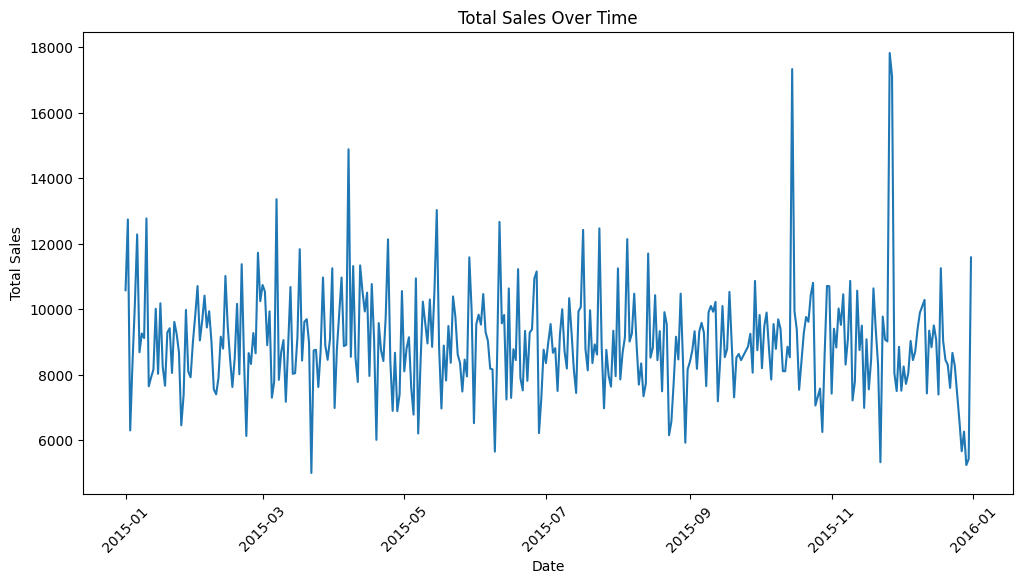

In [75]:
# Ploting sales over time
sales_over_time = merged_data.groupby('order_date')['total_price'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=sales_over_time, x='order_date', y='total_price')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

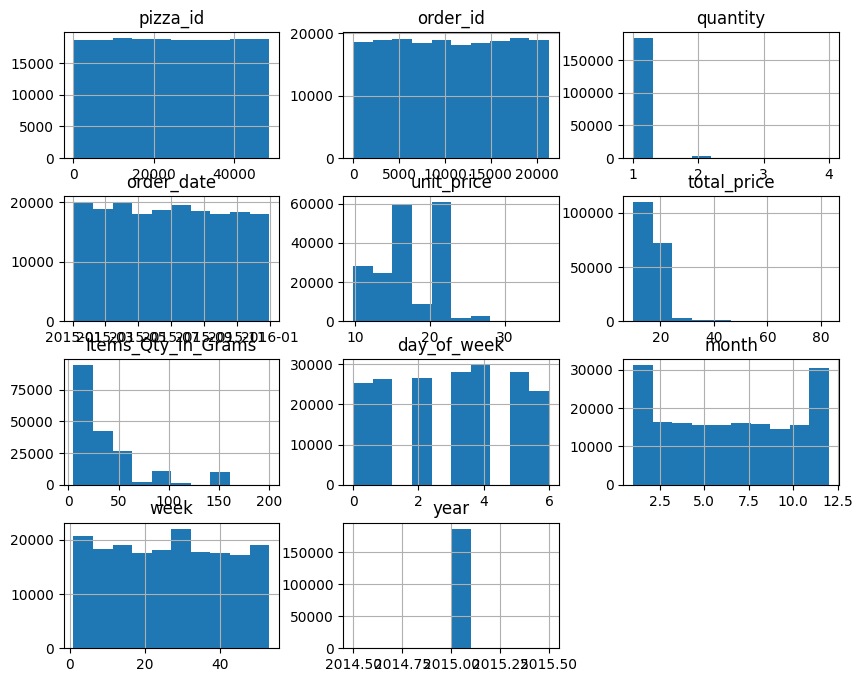

In [76]:
merged_data.hist(figsize=(10,8))
plt.show()

Top-Selling Pizzas

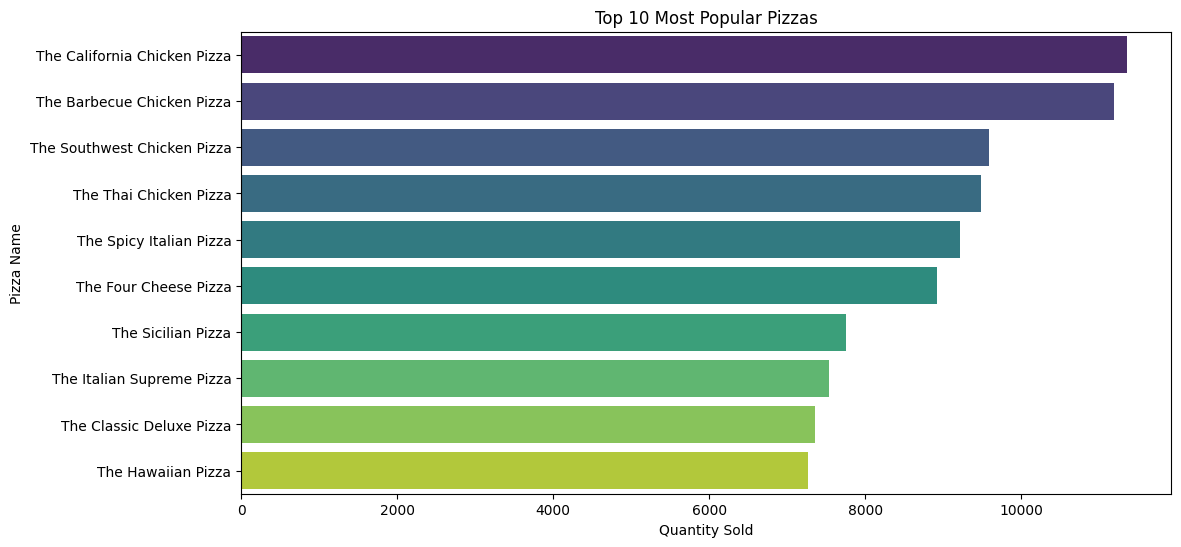

In [77]:
# Aggregate sales by pizza name
pizza_sales = merged_data.groupby('pizza_name')['quantity'].sum().reset_index()

# Sorting by quantity sold
pizza_sales = pizza_sales.sort_values(by='quantity', ascending=False)

# Ploting top 10 most popular pizzas
plt.figure(figsize=(12,6))
sns.barplot(data=pizza_sales.head(10), x='quantity', y='pizza_name', palette='viridis')
plt.title('Top 10 Most Popular Pizzas')
plt.xlabel('Quantity Sold')
plt.ylabel('Pizza Name')
plt.show()

Sales by Pizza Size and Category

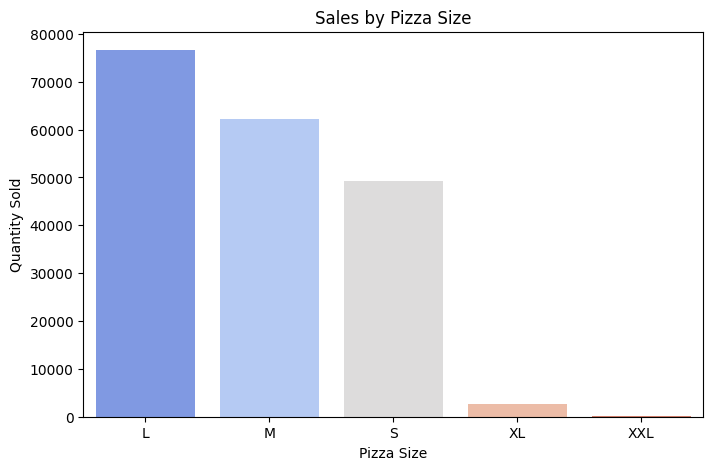

In [78]:
# Ploting pizza size distribution
size_sales = merged_data.groupby('pizza_size')['quantity'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=size_sales, x='pizza_size', y='quantity', palette='coolwarm')
plt.title('Sales by Pizza Size')
plt.xlabel('Pizza Size')
plt.ylabel('Quantity Sold')
plt.show()

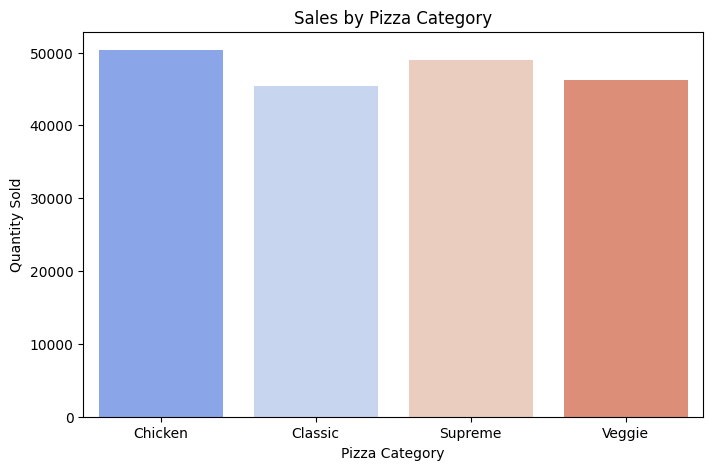

In [79]:
# Ploting pizza category distribution
category_sales = merged_data.groupby('pizza_category')['quantity'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=category_sales, x='pizza_category', y='quantity', palette='coolwarm')
plt.title('Sales by Pizza Category')
plt.xlabel('Pizza Category')
plt.ylabel('Quantity Sold')
plt.show()

Seasonal Sales Trends and Patterns

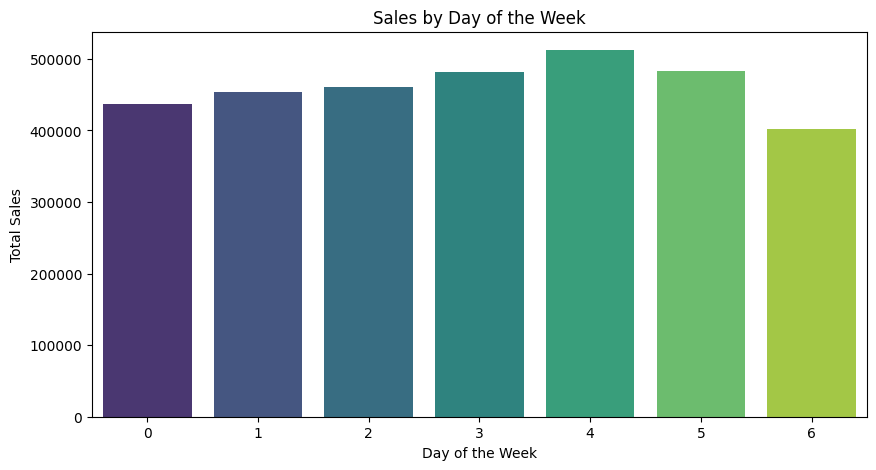

In [80]:
# Aggregate sales by day of the week
sales_by_day = merged_data.groupby('day_of_week')['total_price'].sum().reset_index()

# Order days of the week
#days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_order = [0, 1, 2, 3, 4, 5, 6]
sales_by_day['day_of_week'] = pd.Categorical(sales_by_day['day_of_week'], categories=days_order, ordered=True)

# Plot sales by day of the week
plt.figure(figsize=(10,5))
sns.barplot(data=sales_by_day, x='day_of_week', y='total_price', palette='viridis')
plt.title('Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.show()

Sales by Month

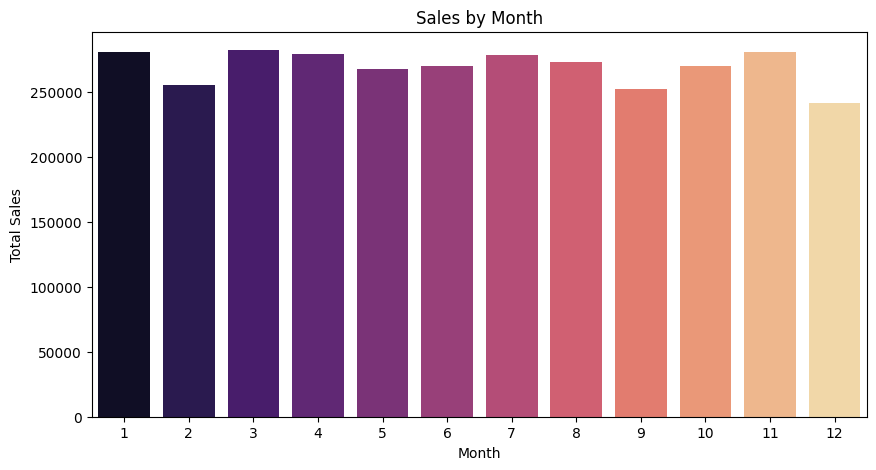

In [81]:
# Aggregate sales by month
sales_by_month = merged_data.groupby('month')['total_price'].sum().reset_index()

# Plot sales by month
plt.figure(figsize=(10,5))
sns.barplot(data=sales_by_month, x='month', y='total_price', palette='magma')
plt.title('Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

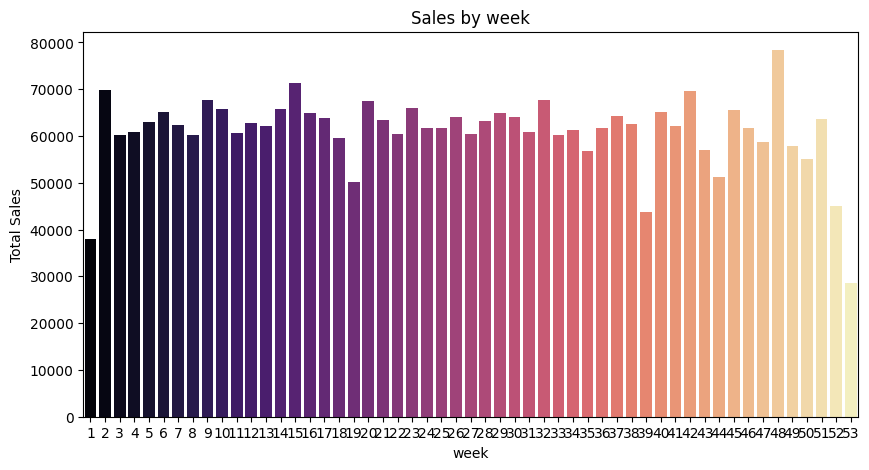

In [82]:
# Aggregate sales by month
sales_by_month = merged_data.groupby('week')['total_price'].sum().reset_index()

# Plot sales by month
plt.figure(figsize=(10,5))
sns.barplot(data=sales_by_month, x='week', y='total_price', palette='magma')
plt.title('Sales by week')
plt.xlabel('week')
plt.ylabel('Total Sales')
plt.show()

Correlation Analysis of Sales Metrics

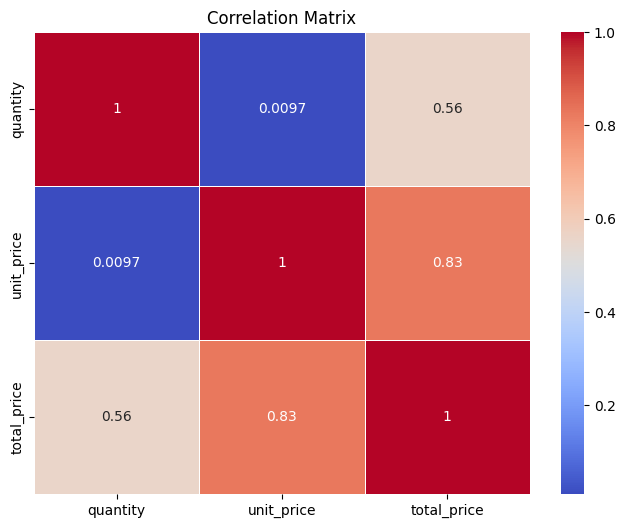

In [83]:
# Correlation matrix
corr_matrix = merged_data[['quantity', 'unit_price', 'total_price']].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Outlier Detection in Sales Data

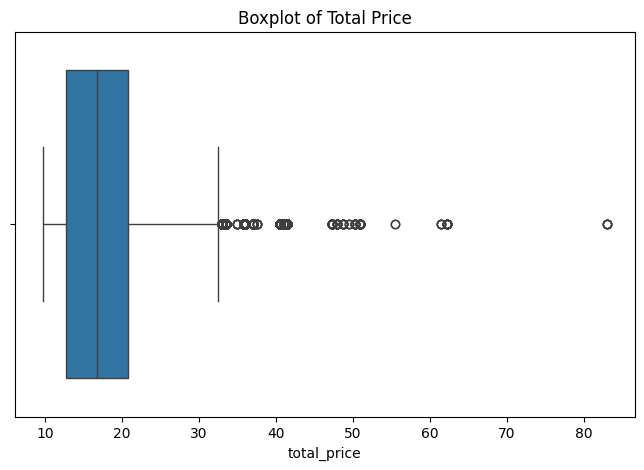

In [84]:
# Boxplot for total_price
plt.figure(figsize=(8,5))
sns.boxplot(data=merged_data, x='total_price')
plt.title('Boxplot of Total Price')
plt.show()

In [85]:
pizza_sales.head()

,pizza_name,quantity
4,The California Chicken Pizza,11351
0,The Barbecue Chicken Pizza,11192
25,The Southwest Chicken Pizza,9585
30,The Thai Chicken Pizza,9484
26,The Spicy Italian Pizza,9213


In [86]:
def prepare_weekly_sales(df):
    # Merging with the original merged_data to get the order_date column
    df = pd.merge(df, merged_data[['pizza_name', 'order_date']], on='pizza_name', how='left')
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(pizza_sales)

print("Weekly Sales:")
print(pizza_sales_weekly)

Weekly Sales:
order_date
2014-12-29    15812735
2015-01-05    28413112
2015-01-12    24957646
2015-01-19    24955081
2015-01-26    25148405
2015-02-02    26410013
2015-02-09    25629751
2015-02-16    24438949
2015-02-23    27059716
2015-03-02    26368633
2015-03-09    24454195
2015-03-16    25741867
2015-03-23    25633611
2015-03-30    26880636
2015-04-06    28508374
2015-04-13    26637857
2015-04-20    25979313
2015-04-27    24362727
2015-05-04    20937239
2015-05-11    27743418
2015-05-18    25411631
2015-05-25    24172378
2015-06-01    26480042
2015-06-08    25321476
2015-06-15    24561935
2015-06-22    26193122
2015-06-29    24139780
2015-07-06    25784981
2015-07-13    26585958
2015-07-20    25757509
2015-07-27    24849195
2015-08-03    27097590
2015-08-10    24655694
2015-08-17    25178039
2015-08-24    22930611
2015-08-31    24913409
2015-09-07    26133704
2015-09-14    25580458
2015-09-21    17589266
2015-09-28    26025427
2015-10-05    25455442
2015-10-12    27823507
2015-10-1

In [87]:
merged_data.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,Items_Qty_In_Grams,day_of_week,month,week,year
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,25.0,3,1,1,2015
1,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,30.0,3,1,1,2015
2,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,20.0,3,1,1,2015
3,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,40.0,3,1,1,2015
6,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,10.0,3,1,1,2015


In [88]:
pizza_sales = merged_data.groupby('week')['quantity'].sum().reset_index()
pizza_sales

,week,quantity
0,1,2247
1,2,4173
2,3,3567
3,4,3674
4,5,3667
5,6,3824
6,7,3634
7,8,3574
8,9,3990
9,10,3891


In [89]:
weekly_sales = merged_data.groupby(merged_data['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
weekly_sales

,quantity
order_date,
2014-12-29,2247
2015-01-05,4173
2015-01-12,3567
2015-01-19,3674
2015-01-26,3667
2015-02-02,3824
2015-02-09,3634
2015-02-16,3574
2015-02-23,3990


In [90]:
weekly_sales = (
    merged_data
    .groupby([merged_data['order_date'].dt.to_period('W').apply(lambda r: r.start_time), 'pizza_name'])['quantity']
    .sum()
    .reset_index()
    .rename(columns={'order_date': 'week_start_date', 'quantity': 'weekly_quantity'})
)
weekly_sales

,week_start_date,pizza_name,weekly_quantity
0,2014-12-29,The Barbecue Chicken Pizza,131
1,2014-12-29,The Big Meat Pizza,60
2,2014-12-29,The Brie Carre Pizza,16
3,2014-12-29,The Calabrese Pizza,44
4,2014-12-29,The California Chicken Pizza,136
...,...,...,...
1691,2015-12-28,The Spinach Pesto Pizza,49
1692,2015-12-28,The Spinach Supreme Pizza,30
1693,2015-12-28,The Spinach and Feta Pizza,40
1694,2015-12-28,The Thai Chicken Pizza,68


In [91]:
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(merged_data)
pizza_sales_weekly

,quantity
order_date,
2014-12-29,2247
2015-01-05,4173
2015-01-12,3567
2015-01-19,3674
2015-01-26,3667
2015-02-02,3824
2015-02-09,3634
2015-02-16,3574
2015-02-23,3990


**Model Selection**

**1.ARIMA Model**

Best ARIMA Model MAPE: 0.1979, Best Parameters: (3, 1, 5)
Predictions:
order_date
2015-10-19    3451.262235
2015-10-26    3835.422480
2015-11-02    3632.952807
2015-11-09    3653.464692
2015-11-16    3555.952125
2015-11-23    3869.830835
2015-11-30    3535.081510
2015-12-07    3663.325830
2015-12-14    3649.173778
2015-12-21    3817.887072
2015-12-28    3465.507998
Name: predicted_mean, dtype: float64


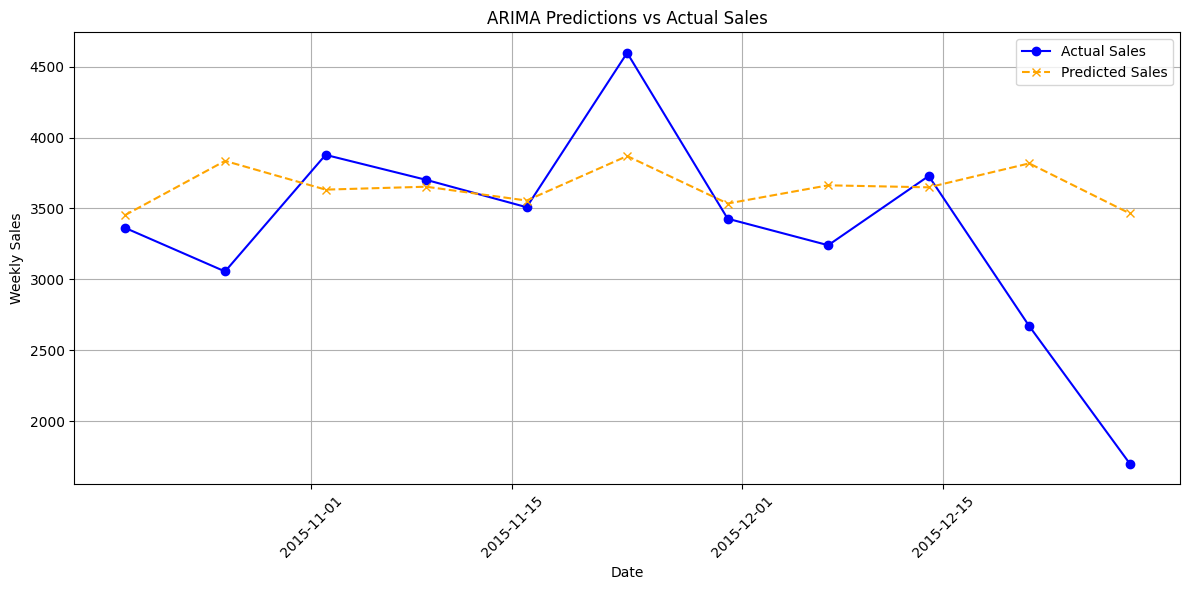

In [92]:
# Pizza sales by week
# Pizza sales by week
# Function to prepare weekly sales
# Pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(merged_data)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# ARIMA Model Tuneing
def tune_arima_model(train, test, p_values, d_values, q_values):
    best_score, best_params, best_predictions = float("inf"), None, None

    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(train, order=(p, d, q)).fit()
            predictions = model.forecast(steps=len(test))
            arima_mape = mape(test, predictions)
            if arima_mape < best_score:
                best_score, best_params, best_predictions = arima_mape, (p, d, q), predictions
        except:
            continue

    print(f"Best ARIMA Model MAPE: {best_score:.4f}, Best Parameters: {best_params}")
    return best_predictions, best_score, best_params

p_values, d_values, q_values = range(0, 6), range(0, 2), range(0, 6)
arima_predictions, arima_mape_score, best_params = tune_arima_model(train, test, p_values, d_values, q_values)

# Formating the predictions for display
arima_predictions = pd.Series(arima_predictions, index=test.index)

print("Predictions:")
print(arima_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(arima_predictions.index, arima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('ARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

New Best Model: ARIMA(0, 0, 0) - MAPE: 0.2136
New Best Model: ARIMA(0, 0, 1) - MAPE: 0.2112
New Best Model: ARIMA(0, 0, 2) - MAPE: 0.2111
New Best Model: ARIMA(0, 0, 6) - MAPE: 0.2105
New Best Model: ARIMA(0, 1, 5) - MAPE: 0.2091
New Best Model: ARIMA(0, 1, 6) - MAPE: 0.2066
New Best Model: ARIMA(0, 2, 3) - MAPE: 0.2065
New Best Model: ARIMA(0, 2, 4) - MAPE: 0.2056
New Best Model: ARIMA(1, 2, 3) - MAPE: 0.2020
New Best Model: ARIMA(3, 1, 5) - MAPE: 0.1979
New Best Model: ARIMA(4, 2, 3) - MAPE: 0.1942
New Best Model: ARIMA(4, 2, 5) - MAPE: 0.1858
New Best Model: ARIMA(5, 3, 6) - MAPE: 0.1704

Best ARIMA Model: ARIMA(5, 3, 6) - MAPE: 0.1704

Best Parameters: (5, 3, 6)
Best ARIMA Model MAPE: 0.1704


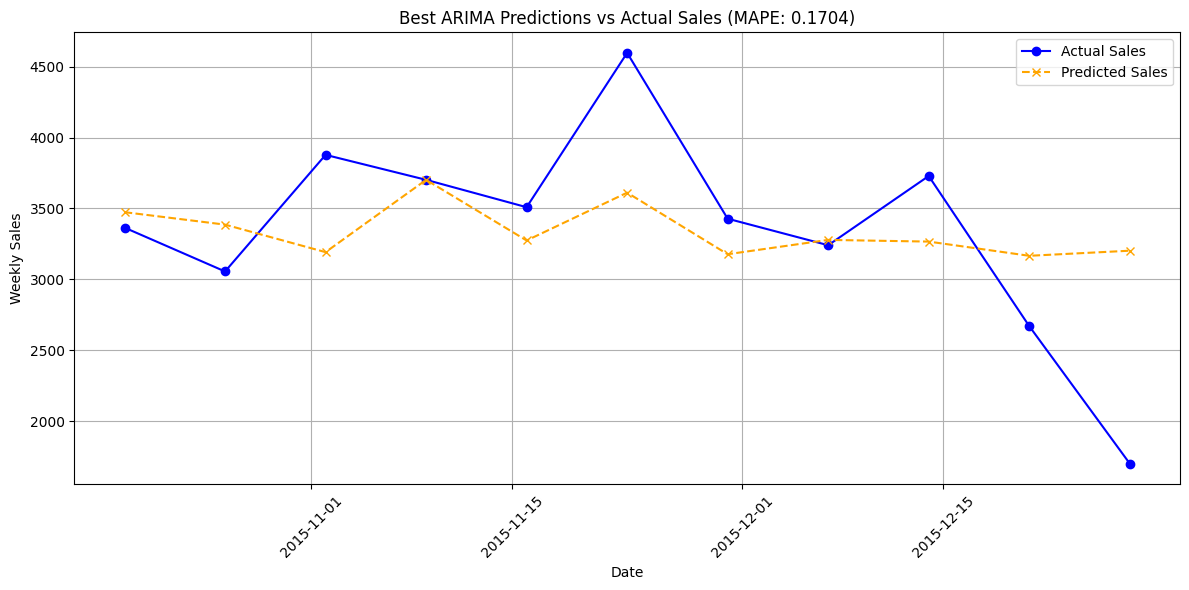

In [93]:
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# Function to tune ARIMA model
def tune_arima_model(train, test, p_values, d_values, q_values):
    best_score, best_params, best_predictions = float("inf"), None, None

    # Iterate through all combinations of parameters
    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            # Fit ARIMA model
            model = ARIMA(train, order=(p, d, q)).fit()

            # Forecast and calculate MAPE
            predictions = model.forecast(steps=len(test))
            arima_mape = mape(test, predictions)

            # Update best parameters if current model is better
            if arima_mape < best_score:
                best_score, best_params, best_predictions = arima_mape, (p, d, q), predictions
                print(f"New Best Model: ARIMA{(p, d, q)} - MAPE: {arima_mape:.4f}")

        except Exception as e:
            continue

    print(f"\nBest ARIMA Model: ARIMA{best_params} - MAPE: {best_score:.4f}")
    return best_predictions, best_score, best_params

# Load and prepare data
# Assuming `pizza_sales` and `merged_data` are already loaded into the environment
pizza_sales_weekly = prepare_weekly_sales(merged_data)

# Train-test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Define parameter ranges for ARIMA
p_values = range(0, 7)  # AR terms
d_values = range(0, 4)  # Differencing terms
q_values = range(0, 7)  # MA terms

# Tune ARIMA model
arima_predictions, arima_mape_score, best_params = tune_arima_model(train, test, p_values, d_values, q_values)

# Format predictions for display
arima_predictions = pd.Series(arima_predictions, index=test.index)

# Display best parameters and MAPE
print(f"\nBest Parameters: {best_params}")
print(f"Best ARIMA Model MAPE: {arima_mape_score:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(arima_predictions.index, arima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title(f'Best ARIMA Predictions vs Actual Sales (MAPE: {arima_mape_score:.4f})')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


**2.SARIMA (Seasonal ARIMA)**

Best SARIMA Model MAPE: 0.2328
Predictions:
order_date
2015-10-19    3639.479206
2015-10-26    3962.488071
2015-11-02    3803.948042
2015-11-09    3536.239883
2015-11-16    3701.246257
2015-11-23    3810.840014
2015-11-30    3827.943569
2015-12-07    3746.818218
2015-12-14    4015.759006
2015-12-21    3867.235372
2015-12-28    3566.659576
Name: predicted_mean, dtype: float64


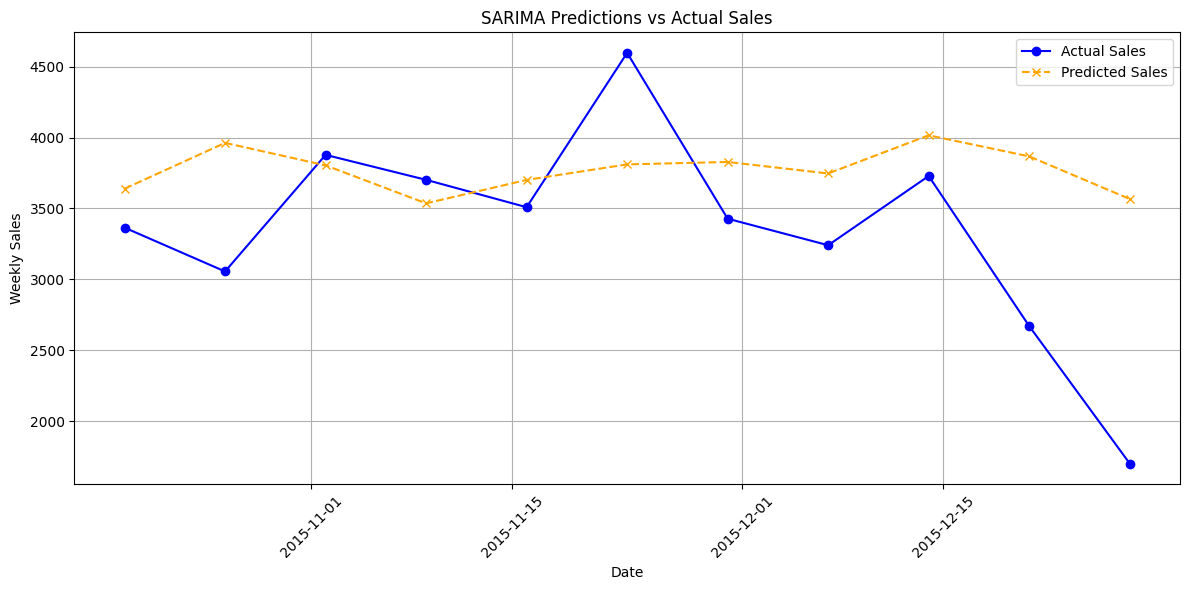

In [94]:
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(merged_data)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# Best SARIMA Model Training and Output
def best_sarima_model(train, test):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit(disp=False)
    predictions = model.forecast(steps=len(test))
    sarima_mape = mape(test, predictions)

    print(f"Best SARIMA Model MAPE: {sarima_mape:.4f}")
    return predictions, sarima_mape

# Train and evaluate the SARIMA model
sarima_predictions, sarima_mape_score = best_sarima_model(train, test)

# Formating the predictions for display
sarima_predictions = pd.Series(sarima_predictions, index=test.index)

print("Predictions:")
print(sarima_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(sarima_predictions.index, sarima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('SARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

New Best Model: SARIMA(0, 0, 0)x(0, 0, 0, 7) - MAPE: 1.0000
New Best Model: SARIMA(0, 0, 0)x(0, 0, 1, 7) - MAPE: 0.7614
New Best Model: SARIMA(0, 0, 0)x(0, 0, 2, 7) - MAPE: 0.6171
New Best Model: SARIMA(0, 0, 0)x(0, 0, 3, 7) - MAPE: 0.5066
New Best Model: SARIMA(0, 0, 0)x(0, 1, 0, 7) - MAPE: 0.1979
New Best Model: SARIMA(0, 0, 0)x(0, 1, 3, 7) - MAPE: 0.1871
New Best Model: SARIMA(0, 0, 0)x(0, 2, 2, 7) - MAPE: 0.1598
New Best Model: SARIMA(0, 0, 0)x(1, 2, 2, 7) - MAPE: 0.1395
New Best Model: SARIMA(0, 0, 3)x(2, 2, 2, 7) - MAPE: 0.1345
New Best Model: SARIMA(2, 0, 0)x(1, 2, 2, 7) - MAPE: 0.1337
New Best Model: SARIMA(2, 0, 2)x(2, 2, 2, 7) - MAPE: 0.1312
New Best Model: SARIMA(2, 1, 1)x(1, 2, 2, 7) - MAPE: 0.1310
New Best Model: SARIMA(2, 1, 3)x(2, 2, 0, 7) - MAPE: 0.1241

Best SARIMA Model: SARIMA(2, 1, 3)x(2, 2, 0, 7) - MAPE: 0.1241
Predictions:
order_date
2015-10-19    3473.656960
2015-10-26    3644.474781
2015-11-02    3526.570341
2015-11-09    2846.347465
2015-11-16    3758.394567
20

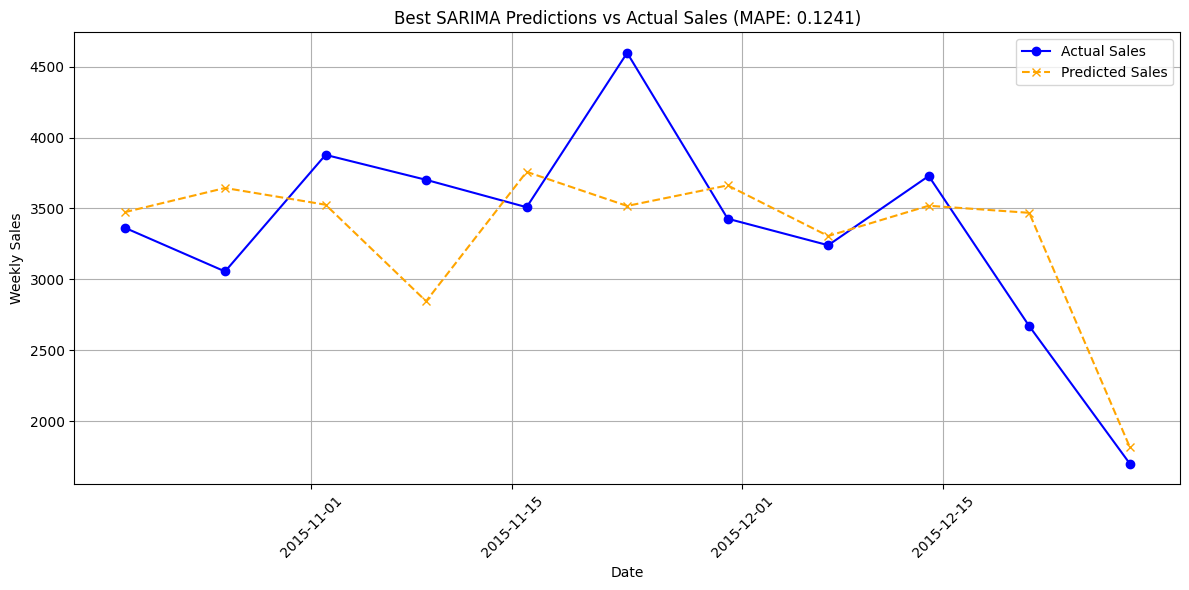

In [97]:
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# Function to tune SARIMA model
def tune_sarima_model(train, test, p_values, d_values, q_values, P_values, D_values, Q_values, s):
    best_score, best_params, best_predictions = float("inf"), None, None

    # Iterate through all combinations of parameters
    for p, d, q, P, D, Q in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values):
        try:
            # Fit SARIMA model
            model = SARIMAX(
                train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=False,
                enforce_invertibility=False,
            ).fit(disp=False)

            # Forecast and calculate MAPE
            predictions = model.forecast(steps=len(test))
            sarima_mape = mape(test, predictions)

            # Update best parameters if current model is better
            if sarima_mape < best_score:
                best_score, best_params, best_predictions = sarima_mape, (p, d, q, P, D, Q, s), predictions
                print(f"New Best Model: SARIMA{(p, d, q)}x{(P, D, Q, s)} - MAPE: {sarima_mape:.4f}")

        except Exception as e:
            continue

    print(f"\nBest SARIMA Model: SARIMA{best_params[:3]}x{best_params[3:]} - MAPE: {best_score:.4f}")
    return best_predictions, best_score, best_params

# Load and prepare data
# Assuming `pizza_sales` and `merged_data` are already loaded into the environment
pizza_sales_weekly = prepare_weekly_sales(merged_data)

# Train-test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Define parameter ranges for SARIMA
p_values = range(0, 4)  # AR terms
d_values = range(0, 3)  # Differencing terms
q_values = range(0, 4)  # MA terms
P_values = range(0, 4)  # Seasonal AR terms
D_values = range(0, 3)  # Seasonal differencing terms
Q_values = range(0, 4)  # Seasonal MA terms
s = 7  # Weekly seasonality

# Tune SARIMA model
sarima_predictions, sarima_mape_score, best_params = tune_sarima_model(
    train, test, p_values, d_values, q_values, P_values, D_values, Q_values, s
)

# Format predictions for display
sarima_predictions = pd.Series(sarima_predictions, index=test.index)


print("Predictions:")
print(sarima_predictions)

# Display best parameters and MAPE
print(f"\nBest Parameters: {best_params}")
print(f"Best SARIMA Model MAPE: {sarima_mape_score:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(sarima_predictions.index, sarima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title(f'Best SARIMA Predictions vs Actual Sales (MAPE: {sarima_mape_score:.4f})')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


**3.Prophet (Developed by Facebook)**

In [98]:
daily_sales

,order_date,quantity
0,2015-01-01,619
1,2015-01-02,741
2,2015-01-03,379
3,2015-01-04,508
4,2015-01-05,594
...,...,...
353,2015-12-27,347
354,2015-12-28,381
355,2015-12-29,302
356,2015-12-30,327


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5_gr8sxx/bcgzvt98.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5_gr8sxx/jhn9el6j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68568', 'data', 'file=/tmp/tmp5_gr8sxx/bcgzvt98.json', 'init=/tmp/tmp5_gr8sxx/jhn9el6j.json', 'output', 'file=/tmp/tmp5_gr8sxx/prophet_model702gyvw5/prophet_model-20241226135418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:54:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:54:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


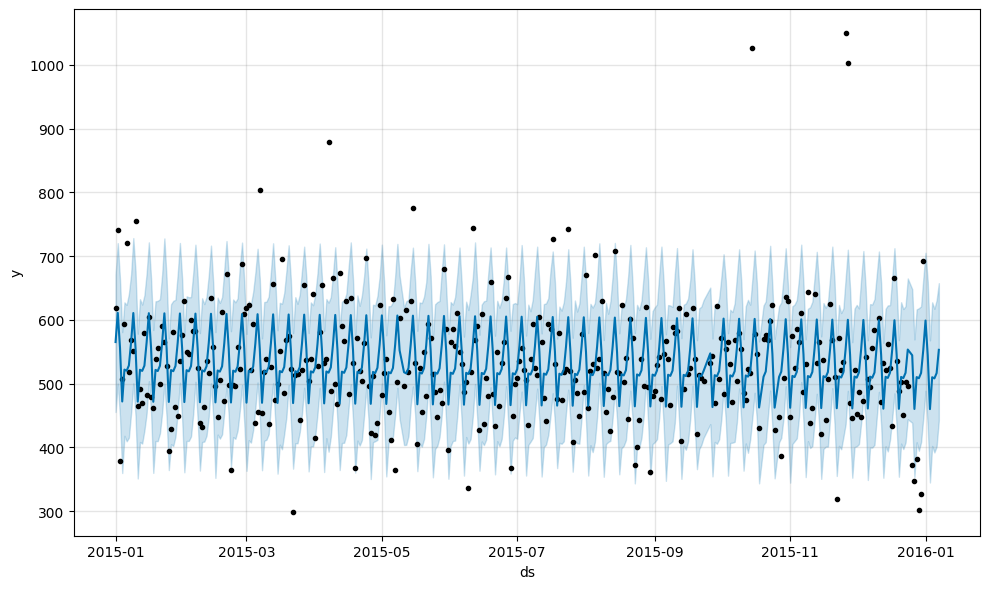

In [99]:
# Prophet model
daily_sales['order_date'] = pd.to_datetime(daily_sales['order_date'])

# renameing the columns to 'ds' for dates and 'y' for the target values
prophet_data = daily_sales.rename(columns={'order_date': 'ds', 'quantity': 'y'})

# Model fiting
prophet_model = Prophet()
#prophet_model.add_country_holidays(country_name='US')
prophet_model.fit(prophet_data)

# Future forecast for the next 7 days
future_dates = prophet_model.make_future_dataframe(periods=7)
prophet_forecast = prophet_model.predict(future_dates)

# Displaying the forecast
fig = prophet_model.plot(prophet_forecast)

In [102]:
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    weekly_sales.columns = ['ds', 'y']
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(merged_data)
pizza_sales_weekly

,quantity
order_date,
2014-12-29,2247
2015-01-05,4173
2015-01-12,3567
2015-01-19,3674
2015-01-26,3667
2015-02-02,3824
2015-02-09,3634
2015-02-16,3574
2015-02-23,3990


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5_gr8sxx/75b1hqvg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5_gr8sxx/8qs8qjg8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26270', 'data', 'file=/tmp/tmp5_gr8sxx/75b1hqvg.json', 'init=/tmp/tmp5_gr8sxx/8qs8qjg8.json', 'output', 'file=/tmp/tmp5_gr8sxx/prophet_modelpvda80jh/prophet_model-20241226135844.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:58:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:58:44 - cmdstanpy - INFO - Chai

Best Prophet Model MAPE: 0.2155
Predictions:
ds
2015-10-19    3680.150112
2015-10-26    3680.681768
2015-11-02    3681.213425
2015-11-09    3681.745082
2015-11-16    3682.276738
2015-11-23    3682.808395
2015-11-30    3683.340052
2015-12-07    3683.871708
2015-12-14    3684.403365
2015-12-21    3684.935021
2015-12-28    3685.466678
dtype: float64


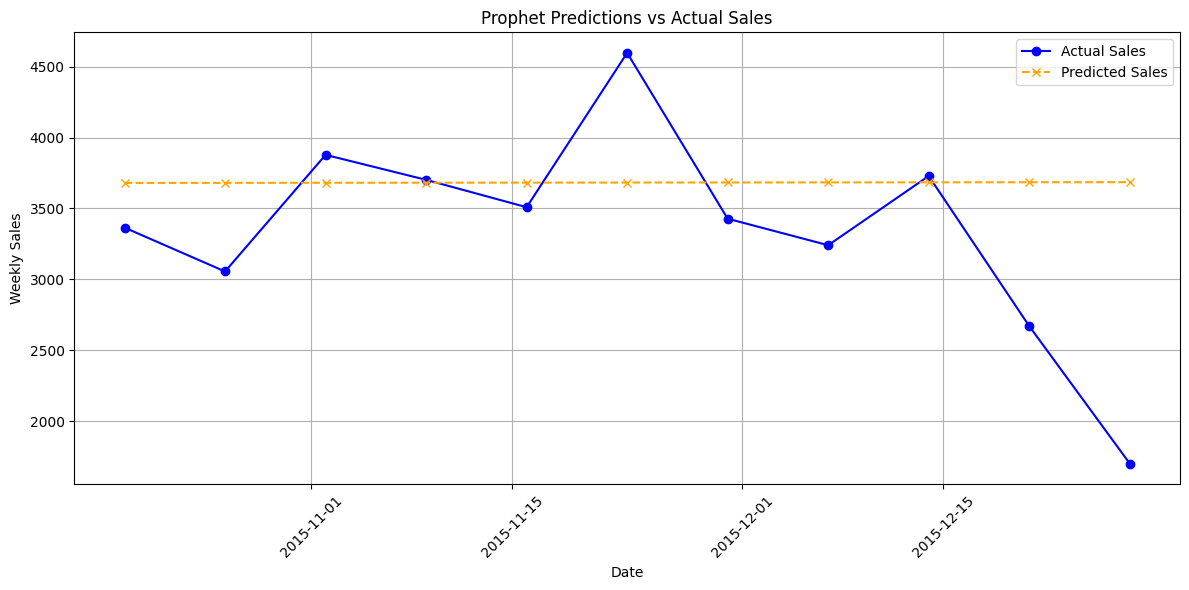

In [103]:
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    # Resetting the index to create a DataFrame and renaming columns
    weekly_sales.columns = ['ds', 'y']  # Now 'ds' and 'y' are columns
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(merged_data)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# Best Prophet Model Training and Output
def best_prophet_model(train, test):
    model = Prophet()

    # Fitting the model with the correctly named columns 'ds' and 'y'
    model.fit(train[['ds', 'y']]) # Pass train DataFrame to fit with proper columns

    future = model.make_future_dataframe(periods=len(test), freq='W')
    forecast = model.predict(future)
    predictions = forecast['yhat'][-len(test):].values

    # Ensure that test['y'] is used for calculating MAPE
    prophet_mape = mape(test['y'].values, predictions)

    print(f"Best Prophet Model MAPE: {prophet_mape:.4f}")
    return predictions, prophet_mape

# Train and evaluate the Prophet model
prophet_predictions, prophet_mape_score = best_prophet_model(train, test)

# Formating the predictions for display
prophet_predictions = pd.Series(prophet_predictions, index=test['ds'])

print("Predictions:")
print(prophet_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], test['y'], label='Actual Sales', color='blue', marker='o')
plt.plot(prophet_predictions.index, prophet_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('Prophet Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

**4.Regression:**

Best Regression Model MAPE: 0.1906
Predictions:
order_date
2015-10-19    3593.595680
2015-10-26    3540.502881
2015-11-02    3700.867712
2015-11-09    3647.774913
2015-11-16    3594.682115
2015-11-23    3541.589316
2015-11-30    3488.496518
2015-12-07    3648.861348
2015-12-14    3595.768550
2015-12-21    3542.675751
2015-12-28    3489.582953
dtype: float64


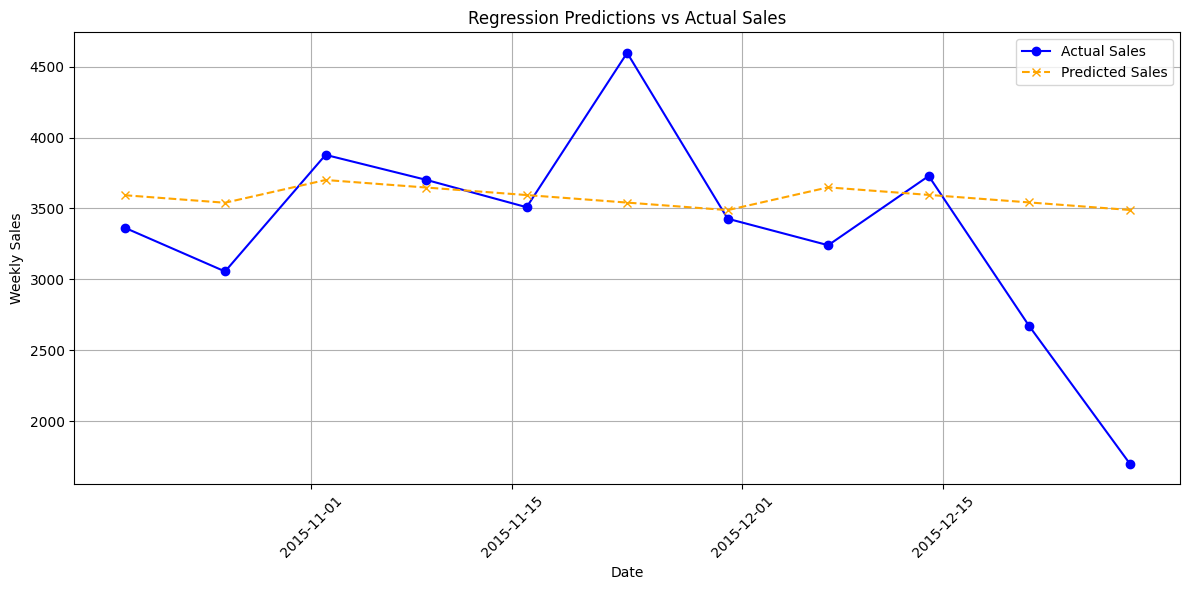

In [105]:
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    # Group by week and sum quantities and then reset index to get 'order_date' as a column
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    # Rename the grouping column to 'order_date' for consistency
    weekly_sales.columns = ['order_date', 'quantity']
    return weekly_sales

def create_regression_features(df):
    df['week_of_year'] = df['order_date'].dt.isocalendar().week
    df['day_of_week'] = df['order_date'].dt.dayofweek
    df['month'] = df['order_date'].dt.month
    df['year'] = df['order_date'].dt.year
    return df

pizza_sales_weekly = prepare_weekly_sales(merged_data)

pizza_sales_weekly = create_regression_features(pizza_sales_weekly)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Prepareing data for Regression
X_train = train[['week_of_year', 'day_of_week', 'month', 'year']]
y_train = train['quantity']
X_test = test[['week_of_year', 'day_of_week', 'month', 'year']]
y_test = test['quantity']

# Best Regression Model Training and Output
def best_regression_model(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    regression_mape = mape(y_test, predictions)

    print(f"Best Regression Model MAPE: {regression_mape:.4f}")
    return predictions, regression_mape

# Train and evaluate the Regression model
regression_predictions, regression_mape_score = best_regression_model(X_train, y_train, X_test, y_test)

# Formating the predictions for display
regression_predictions = pd.Series(regression_predictions, index=test['order_date'])

print("Predictions:")
print(regression_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['order_date'], y_test, label='Actual Sales', color='blue', marker='o')
plt.plot(regression_predictions.index, regression_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('Regression Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

**5.XGBOOST:**

Best XGBoost Model MAPE: 0.3110
Predictions:
order_date
2015-10-19    4072.089355
2015-10-26    4072.089355
2015-11-02    4072.089355
2015-11-09    4072.089355
2015-11-16    4072.089355
2015-11-23    4072.089355
2015-11-30    4072.089355
2015-12-07    4072.089355
2015-12-14    4072.089355
2015-12-21    4072.089355
2015-12-28    4072.089355
dtype: float32


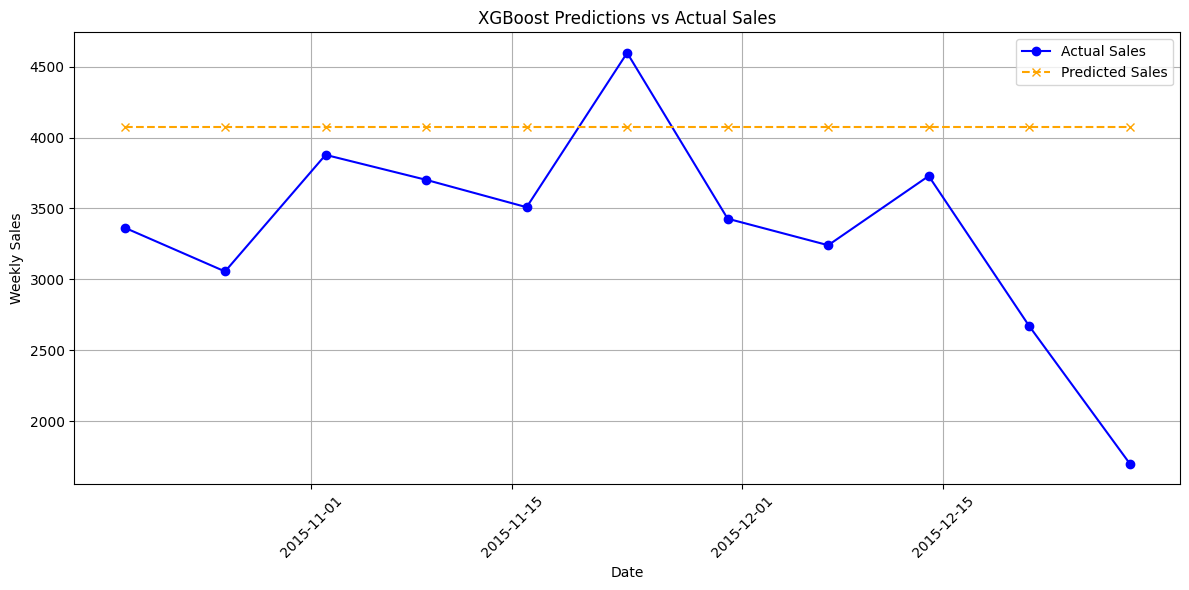

In [107]:
from xgboost import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    # Group by week and sum quantities and then reset index to get 'order_date' as a column
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    # Rename the grouping column to 'order_date' for consistency
    weekly_sales.columns = ['order_date', 'quantity']
    return weekly_sales

def create_regression_features(df):
    df['week_of_year'] = df['order_date'].dt.isocalendar().week
    df['day_of_week'] = df['order_date'].dt.dayofweek
    df['month'] = df['order_date'].dt.month
    df['year'] = df['order_date'].dt.year
    return df

pizza_sales_weekly = prepare_weekly_sales(merged_data)
pizza_sales_weekly = create_regression_features(pizza_sales_weekly)

# Train-test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Preparing data for regression
X_train = train[['week_of_year', 'day_of_week', 'month', 'year']]
y_train = train['quantity']
X_test = test[['week_of_year', 'day_of_week', 'month', 'year']]
y_test = test['quantity']

# XGBoost Regression Model Training and Output
def best_xgboost_model(X_train, y_train, X_test, y_test):
    # Initialize XGBoost regressor
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    predictions = model.predict(X_test)

    # Calculate MAPE
    regression_mape = mape(y_test, predictions)

    print(f"Best XGBoost Model MAPE: {regression_mape:.4f}")
    return predictions, regression_mape

# Train and evaluate the XGBoost model
regression_predictions, regression_mape_score = best_xgboost_model(X_train, y_train, X_test, y_test)

# Formatting the predictions for display
regression_predictions = pd.Series(regression_predictions, index=test['order_date'])

print("Predictions:")
print(regression_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['order_date'], y_test, label='Actual Sales', color='blue', marker='o')
plt.plot(regression_predictions.index, regression_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('XGBoost Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Best LSTM Model MAPE: 23.7978
Predictions:
order_date
2015-11-09    3506.655762
2015-11-16    3576.677246
2015-11-23    3718.439209
2015-11-30    3834.070068
2015-12-07    3815.777588
2015-12-14    3810.727295
2015-12-21    3534.447754
2015-12-28    3403.435059
dtype: float32


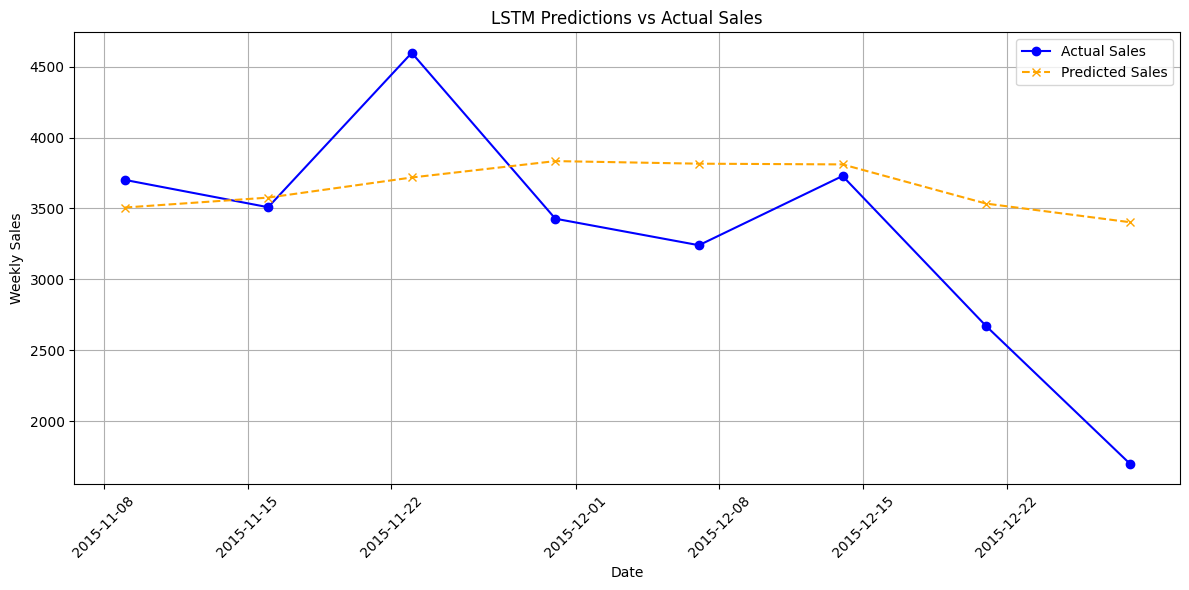

In [116]:
# Pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(merged_data)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Normalizeing the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['quantity']])
test_scaled = scaler.transform(test[['quantity']])

# Prepareing data for LSTM
def create_lstm_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 3
X_train, y_train = create_lstm_dataset(train_scaled, time_steps)
X_test, y_test = create_lstm_dataset(test_scaled, time_steps)

# Reshapeing X for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Training LSTM Model
def best_lstm_model(X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    lstm_mape = mape(y_test_rescaled, predictions)

    print(f"Best LSTM Model MAPE: {lstm_mape:.4f}")
    return predictions, lstm_mape, y_test_rescaled

# Train and evaluate the LSTM model
lstm_predictions, lstm_mape_score, y_test_rescaled = best_lstm_model(X_train, y_train, X_test, y_test)

# Formating the predictions for display
lstm_predictions = pd.Series(lstm_predictions.flatten(), index=test['order_date'][time_steps:])

print("Predictions:")
print(lstm_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['order_date'][time_steps:], y_test_rescaled, label='Actual Sales', color='blue', marker='o')
plt.plot(lstm_predictions.index, lstm_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('LSTM Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Best LSTM Model MAPE: 24.9273
Predictions:
order_date
2015-11-09    3538.968994
2015-11-16    3614.449219
2015-11-23    3789.997314
2015-11-30    3897.174072
2015-12-07    3889.767822
2015-12-14    3906.621094
2015-12-21    3574.543457
2015-12-28    3440.744873
dtype: float32


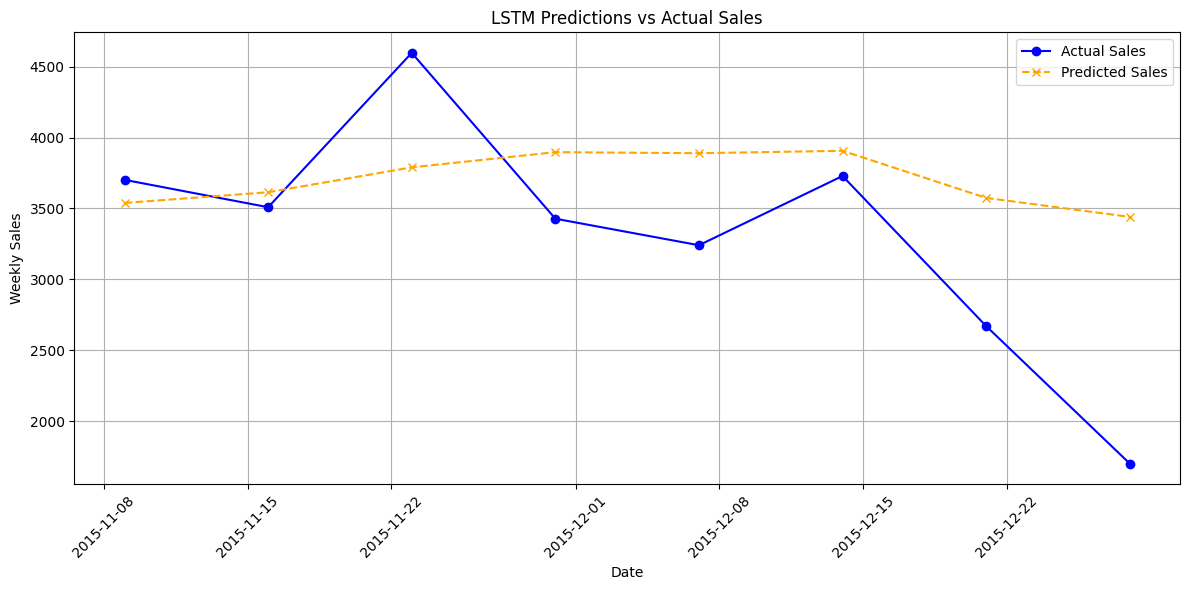

In [118]:
from keras.callbacks import EarlyStopping
# Function to compute MAPE safely
def safe_mape(y_true, y_pred):
    non_zero_indices = y_true != 0  # Avoid division by zero
    y_true_nonzero = y_true[non_zero_indices]
    y_pred_nonzero = y_pred[non_zero_indices]
    return np.mean(np.abs((y_true_nonzero - y_pred_nonzero) / y_true_nonzero)) * 100

# Pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(merged_data)

# Train-test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Normalize the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['quantity']])
test_scaled = scaler.transform(test[['quantity']])

# Prepare data for LSTM
def create_lstm_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 3
X_train, y_train = create_lstm_dataset(train_scaled, time_steps)
X_test, y_test = create_lstm_dataset(test_scaled, time_steps)

# Reshape X for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Training LSTM Model with regularization and tuning
def best_lstm_model(X_train, y_train, X_test, y_test, epochs=50, batch_size=32, lstm_units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(lstm_units, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=False))
    model.add(Dropout(dropout_rate))  # Add dropout for regularization
    model.add(Dense(1, activation='linear'))

    # Compile with Adam optimizer and custom learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    # Add EarlyStopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

    # Fit the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stopping])

    # Make predictions
    predictions = model.predict(X_test)
    predictions_rescaled = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate MAPE
    lstm_mape = safe_mape(y_test_rescaled.flatten(), predictions_rescaled.flatten())
    print(f"Best LSTM Model MAPE: {lstm_mape:.4f}")

    return predictions_rescaled, lstm_mape, y_test_rescaled

# Train and evaluate the LSTM model
lstm_predictions, lstm_mape_score, y_test_rescaled = best_lstm_model(
    X_train, y_train, X_test, y_test, epochs=100, batch_size=16, lstm_units=100, dropout_rate=0.3, learning_rate=0.001
)

# Formatting predictions for display
lstm_predictions = pd.Series(lstm_predictions.flatten(), index=test['order_date'][time_steps:])

print("Predictions:")
print(lstm_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['order_date'][time_steps:], y_test_rescaled, label='Actual Sales', color='blue', marker='o')
plt.plot(lstm_predictions.index, lstm_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('LSTM Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


**## FORECASTINGS:**

In [113]:
# ARIMA Model forecasted sales for the week:

# Aggregate pizza sales by week and pizza type
def prepare_weekly_sales_by_pizza(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['week'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sales_by_pizza = df.groupby(['week', 'pizza_name_id'])['quantity'].sum().reset_index()
    weekly_sales_by_pizza.set_index('week', inplace=True)
    return weekly_sales_by_pizza

pizza_sales_weekly_by_pizza = prepare_weekly_sales_by_pizza(merged_data)

# Function to forecast sales for each pizza type using ARIMA
def forecast_sales_per_pizza_type_arima(pizza_type, train, periods=1):
    model = ARIMA(train, order=(1, 1, 1))
    model_fit = model.fit()

    # Forecasting for the next week
    forecast = model_fit.forecast(steps=periods)
    return pizza_type, forecast.tolist()

# Forecasting next week's sales for each pizza type using ARIMA
def forecast_next_week_sales_by_pizza_type_arima(pizza_sales_weekly_by_pizza, periods=1):
    pizza_type_forecasts = {}

    # Total sales per pizza type
    total_units_sold = pizza_sales_weekly_by_pizza.groupby('pizza_name_id')['quantity'].sum()

    # Last week in the dataset
    last_week = pizza_sales_weekly_by_pizza.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Looping through each pizza type
    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]

        # train test split
        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]['quantity']

        # Forecast sales using ARIMA
        pizza_type, forecast = forecast_sales_per_pizza_type_arima(pizza_type, train, periods)

        if forecast is not None:
            pizza_type_forecasts[pizza_type] = forecast
        else:
            print(f"Forecast failed for pizza type: {pizza_type}")

    return pizza_type_forecasts, total_units_sold, next_week_start, next_week_end

# Forecasting pizza sales for the next week using ARIMA
next_week_pizza_sales_forecasts_arima, total_units_sold, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type_arima(pizza_sales_weekly_by_pizza, periods=1)

# Displaying the forecasted sales for each pizza type and the total quantity of units sold in the predicted week
print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")
total_forecasted_quantity = 0

for pizza_type, forecast in next_week_pizza_sales_forecasts_arima.items():
    forecast = int(forecast[0])
    next_week_pizza_sales_forecasts_arima[pizza_type]=forecast
    print(f'{pizza_type}: {forecast} pizzas')
    total_forecasted_quantity += forecast

print(f"Total quantity of units sold in the predicted week: {total_forecasted_quantity} pizzas")

Forecasted sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 90 pizzas
bbq_ckn_m: 91 pizzas
bbq_ckn_s: 27 pizzas
big_meat_s: 110 pizzas
brie_carre_s: 37 pizzas
calabrese_l: 19 pizzas
calabrese_m: 40 pizzas
cali_ckn_l: 89 pizzas
cali_ckn_m: 95 pizzas
cali_ckn_s: 42 pizzas
ckn_alfredo_l: 17 pizzas
ckn_alfredo_m: 67 pizzas
ckn_alfredo_s: 10 pizzas
ckn_pesto_l: 30 pizzas
ckn_pesto_m: 18 pizzas
ckn_pesto_s: 20 pizzas
classic_dlx_l: 30 pizzas
classic_dlx_m: 67 pizzas
classic_dlx_s: 45 pizzas
five_cheese_l: 54 pizzas
four_cheese_l: 121 pizzas
four_cheese_m: 44 pizzas
green_garden_l: 11 pizzas
green_garden_m: 23 pizzas
green_garden_s: 47 pizzas
hawaiian_l: 48 pizzas
hawaiian_m: 27 pizzas
hawaiian_s: 56 pizzas
ital_cpcllo_l: 58 pizzas
ital_cpcllo_m: 27 pizzas
ital_cpcllo_s: 21 pizzas
ital_supr_l: 52 pizzas
ital_supr_m: 69 pizzas
ital_supr_s: 15 pizzas
ital_veggie_m: 37 pizzas
ital_veggie_s: 17 pizzas
mediterraneo_l: 34 pizzas
mediterraneo_m: 27 pizzas
mediterraneo_s: 28 pizzas
mexicana_l:

In [114]:
# SARIMA Model forecasted sales for the week:

# Aggregateing pizza sales by week and pizza type
def prepare_weekly_sales_by_pizza(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['week'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sales_by_pizza = df.groupby(['week', 'pizza_name_id'])['quantity'].sum().reset_index()
    weekly_sales_by_pizza.set_index('week', inplace=True)
    return weekly_sales_by_pizza

pizza_sales_weekly_by_pizza = prepare_weekly_sales_by_pizza(merged_data)

# Function to forecast for each pizza type
def forecast_sales_per_pizza_type(pizza_type, train, periods=1):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    model_fit = model.fit(disp=False)

    # Forecasting for the next week
    forecast = model_fit.forecast(steps=periods)
    return pizza_type, forecast.tolist()

# Forecasting for each pizza type for the next week
def forecast_next_week_sales_by_pizza_type(pizza_sales_weekly_by_pizza, periods=1):
    pizza_type_forecasts = {}
    total_units_sold = pizza_sales_weekly_by_pizza.groupby('pizza_name_id')['quantity'].sum()

    # Last week in the dataset
    last_week = pizza_sales_weekly_by_pizza.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Looping through each pizza type
    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]

        # train test data
        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]['quantity']
        pizza_type, forecast = forecast_sales_per_pizza_type(pizza_type, train, periods)

        if forecast:
            pizza_type_forecasts[pizza_type] = forecast[0]  # Access the first value of the forecast list

    return pizza_type_forecasts, total_units_sold, next_week_start, next_week_end

# Forecasting pizza sales for the next week
next_week_pizza_sales_forecasts, total_units_sold, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type(pizza_sales_weekly_by_pizza, periods=1)

# Displaying the forecasted sales for each pizza type and the total quantity of units sold in the predicted week
print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")

total_forecasted_quantity = 0

for pizza_type, forecast in next_week_pizza_sales_forecasts.items():
    forecast = int(forecast)
    next_week_pizza_sales_forecasts[pizza_type]=forecast
    print(f'{pizza_type}: {forecast} pizzas')
    total_forecasted_quantity += forecast

# Displaying the total quantity of units sold in the predicted week
print(f"Total quantity of units sold in the predicted week: {total_forecasted_quantity} pizzas")

Forecasted sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 69 pizzas
bbq_ckn_m: 110 pizzas
bbq_ckn_s: 31 pizzas
big_meat_s: 102 pizzas
brie_carre_s: 46 pizzas
calabrese_l: 14 pizzas
calabrese_m: 35 pizzas
cali_ckn_l: 95 pizzas
cali_ckn_m: 80 pizzas
cali_ckn_s: 35 pizzas
ckn_alfredo_l: 19 pizzas
ckn_alfredo_m: 61 pizzas
ckn_alfredo_s: 11 pizzas
ckn_pesto_l: 34 pizzas
ckn_pesto_m: 17 pizzas
ckn_pesto_s: 15 pizzas
classic_dlx_l: 28 pizzas
classic_dlx_m: 66 pizzas
classic_dlx_s: 43 pizzas
five_cheese_l: 47 pizzas
four_cheese_l: 166 pizzas
four_cheese_m: 46 pizzas
green_garden_l: 6 pizzas
green_garden_m: 36 pizzas
green_garden_s: 39 pizzas
hawaiian_l: 47 pizzas
hawaiian_m: 17 pizzas
hawaiian_s: 49 pizzas
ital_cpcllo_l: 58 pizzas
ital_cpcllo_m: 44 pizzas
ital_cpcllo_s: 33 pizzas
ital_supr_l: 57 pizzas
ital_supr_m: 71 pizzas
ital_supr_s: 11 pizzas
ital_veggie_m: 41 pizzas
ital_veggie_s: 13 pizzas
mediterraneo_l: 37 pizzas
mediterraneo_m: 36 pizzas
mediterraneo_s: 24 pizzas
mexicana_l:

In [115]:
# Function to forecast sales for each pizza type using Prophet
def forecast_sales_per_pizza_type_prophet(pizza_type, train, periods=1):
    # Prepare the data for Prophet
    train_prophet = train.reset_index().rename(columns={'week': 'ds', 'quantity': 'y'})

    # Fit the Prophet model
    model = Prophet()
    model.fit(train_prophet)

    # Create a DataFrame to hold the future dates
    future = model.make_future_dataframe(periods=periods)

    # Forecasting
    forecast = model.predict(future)
    return pizza_type, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(periods)

# Forecasting next week's sales for each pizza type using Prophet
def forecast_next_week_sales_by_pizza_type_prophet(pizza_sales_weekly_by_pizza, periods=7):
    pizza_type_forecasts = {}

    # Last week in the dataset
    last_week = pizza_sales_weekly_by_pizza.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Looping through each pizza type
    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]

        # Train-test split
        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]

        # Forecast sales using Prophet
        pizza_type, forecast = forecast_sales_per_pizza_type_prophet(pizza_type, train, periods)

        if forecast is not None:
            pizza_type_forecasts[pizza_type] = forecast['yhat'].sum()  # Total forecasted sales for the week
        else:
            print(f"Forecast failed for pizza type: {pizza_type}")

    return pizza_type_forecasts, next_week_start, next_week_end

# Forecasting pizza sales for the next week using Prophet
next_week_pizza_sales_forecasts_prophet, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type_prophet(pizza_sales_weekly_by_pizza)

# Displaying the forecasted sales for each pizza type and the total quantity of units sold in the predicted week
print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")
total_forecasted_quantity = sum(next_week_pizza_sales_forecasts_prophet.values())

for pizza_type, forecast in next_week_pizza_sales_forecasts_prophet.items():
    print(f'{pizza_type}: {int(forecast)} pizzas')

print(f"Total quantity of units sold in the predicted week: {int(total_forecasted_quantity)} pizzas")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5_gr8sxx/7equ8txs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5_gr8sxx/kyqektp8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52625', 'data', 'file=/tmp/tmp5_gr8sxx/7equ8txs.json', 'init=/tmp/tmp5_gr8sxx/kyqektp8.json', 'output', 'file=/tmp/tmp5_gr8sxx/prophet_modelpw46_0y2/prophet_model-20241226174049.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:40:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:49 - cmdstanpy - INFO - Chai

Forecasted sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 585 pizzas
bbq_ckn_m: 673 pizzas
bbq_ckn_s: 190 pizzas
big_meat_s: 807 pizzas
brie_carre_s: 269 pizzas
calabrese_l: 147 pizzas
calabrese_m: 280 pizzas
cali_ckn_l: 651 pizzas
cali_ckn_m: 596 pizzas
cali_ckn_s: 266 pizzas
ckn_alfredo_l: 135 pizzas
ckn_alfredo_m: 491 pizzas
ckn_alfredo_s: 72 pizzas
ckn_pesto_l: 209 pizzas
ckn_pesto_m: 144 pizzas
ckn_pesto_s: 162 pizzas
classic_dlx_l: 184 pizzas
classic_dlx_m: 482 pizzas
classic_dlx_s: 347 pizzas
five_cheese_l: 363 pizzas
four_cheese_l: 891 pizzas
four_cheese_m: 312 pizzas
green_garden_l: 70 pizzas
green_garden_m: 170 pizzas
green_garden_s: 321 pizzas
hawaiian_l: 371 pizzas
hawaiian_m: 201 pizzas
hawaiian_s: 381 pizzas
ital_cpcllo_l: 419 pizzas
ital_cpcllo_m: 199 pizzas
ital_cpcllo_s: 121 pizzas
ital_supr_l: 384 pizzas
ital_supr_m: 480 pizzas
ital_supr_s: 105 pizzas
ital_veggie_m: 264 pizzas
ital_veggie_s: 123 pizzas
mediterraneo_l: 239 pizzas
mediterraneo_m: 170 pizzas
med

**## EVALUATION**

Best ARIMA Model: ARIMA(5, 3, 6) - MAPE: 0.1704

Best Parameters: (2, 1, 3, 2, 2, 0, 7)
Best SARIMA Model MAPE: 0.1241

Best Prophet Model MAPE: 0.2155

Best Regression Model MAPE: 0.1906

Best XGBoost Model MAPE: 0.3110

Best LSTM Model Parameters: epochs=50, batch_size=64 - MAPE: 0.221630

In [93]:
import pandas as pd

# Model results as a dictionary
model_performance = {
    'Model': ['SARIMA', 'ARIMA', 'Regression', 'XGBOOST', 'Prophet', 'LSTM'],
    'MAPE': [0.1241, 0.1704, 0.1906, 0.3110, 0.2155, 0.2216]
}

# Createing a DataFrame
df_performance = pd.DataFrame(model_performance)

# Highlight best and worst models
df_performance['Rank'] = df_performance['MAPE'].rank()
df_performance = df_performance.sort_values('MAPE', ascending=True)
df_performance['Best/Worst'] = df_performance['MAPE'].apply(lambda x: 'Best' if x == df_performance['MAPE'].min() else 'Worst' if x == df_performance['MAPE'].max() else '')

# Display table
df_performance

,Model,MAPE,Rank,Best/Worst
0,SARIMA,0.1241,1.0,Best
1,ARIMA,0.1704,2.0,
2,Regression,0.1906,3.0,
4,Prophet,0.2155,4.0,
5,LSTM,0.2216,5.0,
3,XGBOOST,0.3110,6.0,Worst


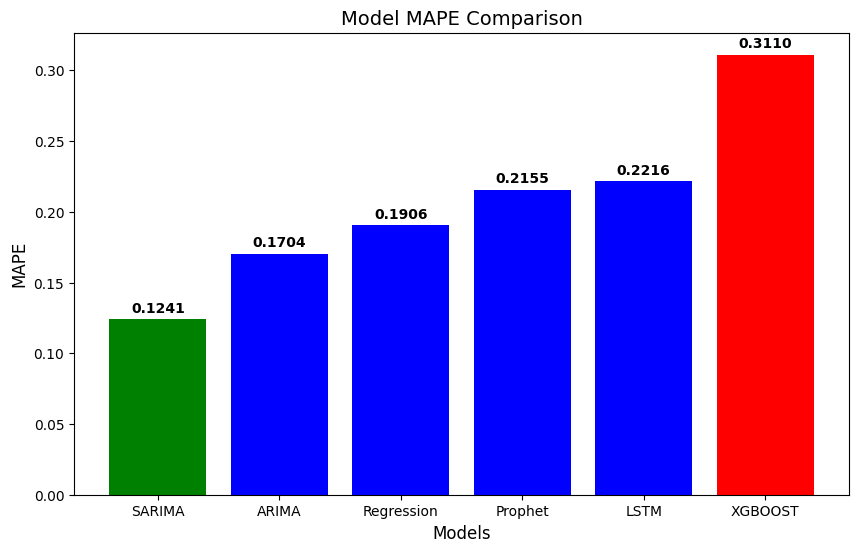

In [94]:
import matplotlib.pyplot as plt

# Data for plotting
models = ['SARIMA', 'ARIMA', 'Regression', 'Prophet', 'LSTM', 'XGBOOST']
mapes = [0.1241, 0.1704, 0.1906, 0.2155, 0.2216, 0.3110]

plt.figure(figsize=(10,6))
plt.bar(models, mapes, color=['green', 'blue', 'blue', 'blue', 'blue', 'red'])

# Highlighting the best and worst models
plt.title('Model MAPE Comparison', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('MAPE', fontsize=12)

for i, v in enumerate(mapes):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

plt.show()

New Best Model: SARIMA(0, 0, 0)x(1, 2, 2, 7) - MAPE: 0.1395
New Best Model: SARIMA(0, 0, 3)x(2, 2, 2, 7) - MAPE: 0.1345
New Best Model: SARIMA(2, 0, 0)x(1, 2, 2, 7) - MAPE: 0.1337
New Best Model: SARIMA(2, 0, 2)x(2, 2, 2, 7) - MAPE: 0.1312
New Best Model: SARIMA(2, 1, 1)x(1, 2, 2, 7) - MAPE: 0.1310
New Best Model: SARIMA(2, 1, 3)x(2, 2, 0, 7) - MAPE: 0.1241

1, 1, 1), seasonal_order=(1, 1, 1, 7

New Best Model: SARIMA(0, 0, 0)x(0, 0, 0, 7) - MAPE: 1.0000
New Best Model: SARIMA(0, 0, 0)x(0, 0, 1, 7) - MAPE: 0.7614
New Best Model: SARIMA(0, 0, 0)x(0, 0, 2, 7) - MAPE: 0.6171
New Best Model: SARIMA(0, 0, 0)x(0, 1, 0, 7) - MAPE: 0.1979
New Best Model: SARIMA(0, 0, 0)x(1, 0, 0, 7) - MAPE: 0.1926
New Best Model: SARIMA(0, 0, 0)x(1, 0, 2, 7) - MAPE: 0.1914
New Best Model: SARIMA(0, 0, 0)x(2, 0, 0, 7) - MAPE: 0.1877
New Best Model: SARIMA(0, 0, 0)x(2, 1, 0, 7) - MAPE: 0.1814
New Best Model: SARIMA(0, 0, 0)x(2, 1, 1, 7) - MAPE: 0.1805
New Best Model: SARIMA(0, 0, 2)x(2, 0, 0, 7) - MAPE: 0.1674
New Best Model: SARIMA(0, 1, 1)x(2, 1, 0, 7) - MAPE: 0.1651
New Best Model: SARIMA(1, 0, 0)x(2, 0, 0, 7) - MAPE: 0.1535
New Best Model: SARIMA(1, 0, 1)x(2, 0, 0, 7) - MAPE: 0.1507

Best SARIMA Model: SARIMA(1, 0, 1)x(2, 0, 0, 7) - MAPE: 0.1507
Predictions:
order_date
2015-10-19    3640.535595
2015-10-26    3680.527073
2015-11-02    3576.580454
2015-11-09    3778.906043
2015-11-16    3540.638024
20

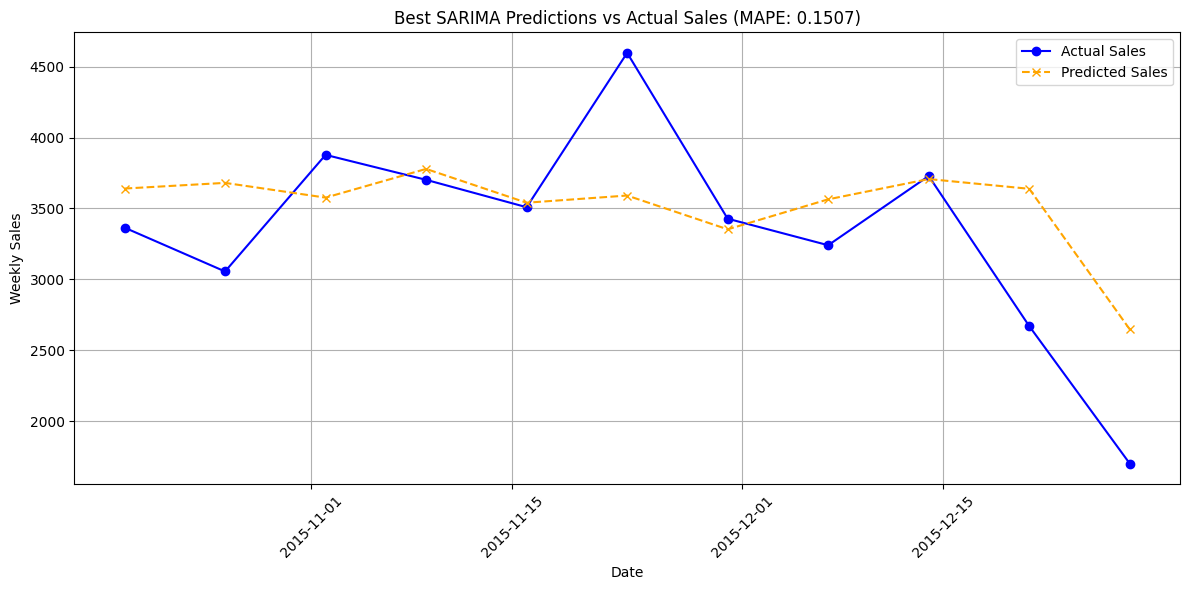

In [95]:
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# Function to tune SARIMA model
def tune_sarima_model(train, test, p_values, d_values, q_values, P_values, D_values, Q_values, s):
    best_score, best_params, best_predictions = float("inf"), None, None

    # Iterate through all combinations of parameters
    for p, d, q, P, D, Q in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values):
        try:
            # Fit SARIMA model
            model = SARIMAX(
                train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=False,
                enforce_invertibility=False,
            ).fit(disp=False)

            # Forecast and calculate MAPE
            predictions = model.forecast(steps=len(test))
            sarima_mape = mape(test, predictions)

            # Update best parameters if current model is better
            if sarima_mape < best_score:
                best_score, best_params, best_predictions = sarima_mape, (p, d, q, P, D, Q, s), predictions
                print(f"New Best Model: SARIMA{(p, d, q)}x{(P, D, Q, s)} - MAPE: {sarima_mape:.4f}")

        except Exception as e:
            continue

    print(f"\nBest SARIMA Model: SARIMA{best_params[:3]}x{best_params[3:]} - MAPE: {best_score:.4f}")
    return best_predictions, best_score, best_params

# Load and prepare data
# Assuming `pizza_sales` and `merged_data` are already loaded into the environment
pizza_sales_weekly = prepare_weekly_sales(merged_data)

# Train-test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Define parameter ranges for SARIMA
p_values = range(0, 3)  # AR terms
d_values = range(0, 2)  # Differencing terms
q_values = range(0, 3)  # MA terms
P_values = range(0, 3)  # Seasonal AR terms
D_values = range(0, 2)  # Seasonal differencing terms
Q_values = range(0, 3)  # Seasonal MA terms
s = 7  # Weekly seasonality

# Tune SARIMA model
sarima_predictions, sarima_mape_score, best_params = tune_sarima_model(
    train, test, p_values, d_values, q_values, P_values, D_values, Q_values, s
)

# Format predictions for display
sarima_predictions = pd.Series(sarima_predictions, index=test.index)


print("Predictions:")
print(sarima_predictions)

# Display best parameters and MAPE
print(f"\nBest Parameters: {best_params}")
print(f"Best SARIMA Model MAPE: {sarima_mape_score:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(sarima_predictions.index, sarima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title(f'Best SARIMA Predictions vs Actual Sales (MAPE: {sarima_mape_score:.4f})')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [96]:
# SARIMA Model forecasted sales for the week:

# Aggregateing pizza sales by week and pizza type
def prepare_weekly_sales_by_pizza(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['week'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sales_by_pizza = df.groupby(['week', 'pizza_name_id'])['quantity'].sum().reset_index()
    weekly_sales_by_pizza.set_index('week', inplace=True)
    return weekly_sales_by_pizza

pizza_sales_weekly_by_pizza = prepare_weekly_sales_by_pizza(merged_data)

# Function to forecast for each pizza type
def forecast_sales_per_pizza_type(pizza_type, train, periods=1):
    model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(2, 0, 0, 7))
    model_fit = model.fit(disp=False)

    # Forecasting for the next week
    forecast = model_fit.forecast(steps=periods)
    return pizza_type, forecast.tolist()

# Forecasting for each pizza type for the next week
def forecast_next_week_sales_by_pizza_type(pizza_sales_weekly_by_pizza, periods=1):
    pizza_type_forecasts = {}
    total_units_sold = pizza_sales_weekly_by_pizza.groupby('pizza_name_id')['quantity'].sum()

    # Last week in the dataset
    last_week = pizza_sales_weekly_by_pizza.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Looping through each pizza type
    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]

        # train test data
        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]['quantity']
        pizza_type, forecast = forecast_sales_per_pizza_type(pizza_type, train, periods)

        if forecast:
            pizza_type_forecasts[pizza_type] = forecast[0]  # Access the first value of the forecast list

    return pizza_type_forecasts, total_units_sold, next_week_start, next_week_end

# Forecasting pizza sales for the next week
next_week_pizza_sales_forecasts, total_units_sold, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type(pizza_sales_weekly_by_pizza, periods=1)

# Displaying the forecasted sales for each pizza type and the total quantity of units sold in the predicted week
print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")

total_forecasted_quantity = 0

for pizza_type, forecast in next_week_pizza_sales_forecasts.items():
    forecast = int(forecast)
    next_week_pizza_sales_forecasts[pizza_type]=forecast
    print(f'{pizza_type}: {forecast} pizzas')
    total_forecasted_quantity += forecast

# Displaying the total quantity of units sold in the predicted week
print(f"Total quantity of units sold in the predicted week: {total_forecasted_quantity} pizzas")

Forecasted sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 86 pizzas
bbq_ckn_m: 95 pizzas
bbq_ckn_s: 25 pizzas
big_meat_s: 107 pizzas
brie_carre_s: 34 pizzas
calabrese_l: 14 pizzas
calabrese_m: 35 pizzas
cali_ckn_l: 85 pizzas
cali_ckn_m: 91 pizzas
cali_ckn_s: 38 pizzas
ckn_alfredo_l: 22 pizzas
ckn_alfredo_m: 68 pizzas
ckn_alfredo_s: 7 pizzas
ckn_pesto_l: 29 pizzas
ckn_pesto_m: 22 pizzas
ckn_pesto_s: 21 pizzas
classic_dlx_l: 27 pizzas
classic_dlx_m: 68 pizzas
classic_dlx_s: 45 pizzas
five_cheese_l: 53 pizzas
four_cheese_l: 121 pizzas
four_cheese_m: 43 pizzas
green_garden_l: 8 pizzas
green_garden_m: 29 pizzas
green_garden_s: 36 pizzas
hawaiian_l: 54 pizzas
hawaiian_m: 23 pizzas
hawaiian_s: 56 pizzas
ital_cpcllo_l: 57 pizzas
ital_cpcllo_m: 41 pizzas
ital_cpcllo_s: 21 pizzas
ital_supr_l: 61 pizzas
ital_supr_m: 52 pizzas
ital_supr_s: 14 pizzas
ital_veggie_m: 37 pizzas
ital_veggie_s: 17 pizzas
mediterraneo_l: 31 pizzas
mediterraneo_m: 22 pizzas
mediterraneo_s: 26 pizzas
mexicana_l: 6


Prediction for week 2016-01-04 to 2016-01-10:
2016-01-04    3601.499082
Freq: W-MON, dtype: float64


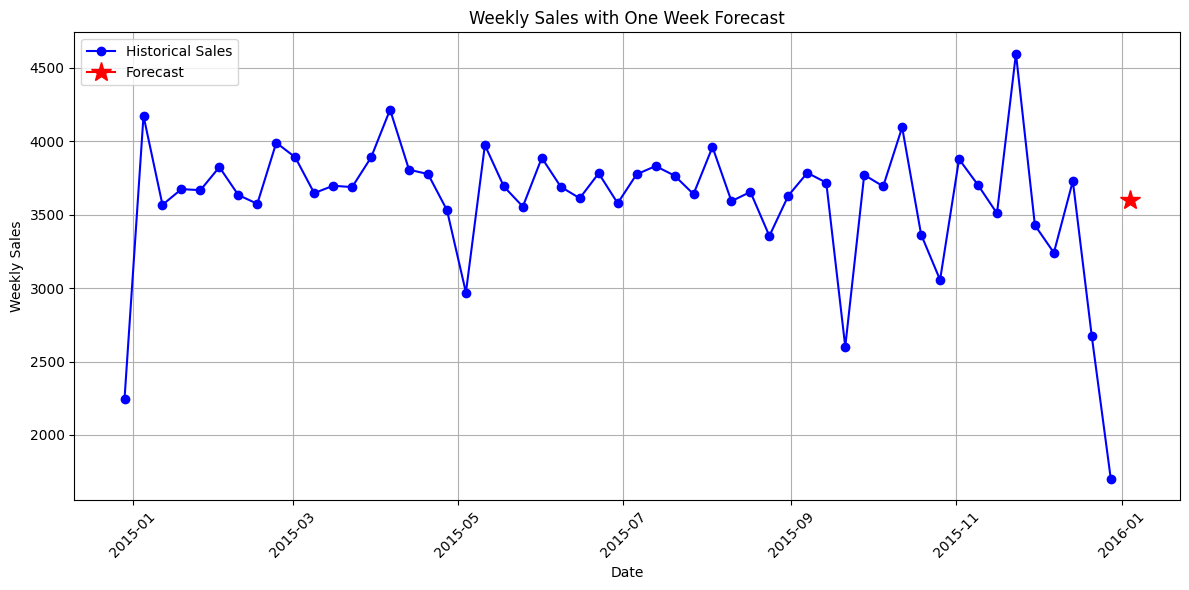


Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                           quantity   No. Observations:                   53
Model:             SARIMAX(1, 0, 1)x(2, 0, [], 7)   Log Likelihood                -280.489
Date:                            Fri, 27 Dec 2024   AIC                            570.977
Time:                                    04:13:52   BIC                            579.165
Sample:                                12-29-2014   HQIC                           573.890
                                     - 12-28-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2704      0.356     -0.759      0.448      -0.969       0.428
ma.L1          0.54

In [97]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Prepare the weekly sales data
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    # Group by week and sum the quantities
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

# Prepare the data using all available observations
pizza_sales_weekly = prepare_weekly_sales(merged_data)

# Since we found the best parameters earlier, we'll use them directly
# SARIMA(1, 0, 1)x(2, 0, 0, 7) was our best model
best_params = (1, 0, 1, 2, 0, 0, 7)

# Fit the SARIMAX model using the entire dataset
model = SARIMAX(
    pizza_sales_weekly,
    order=(best_params[0], best_params[1], best_params[2]),
    seasonal_order=(best_params[3], best_params[4], best_params[5], best_params[6]),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Predict one week ahead (2016-01-04 to 2016-01-10)
forecast = model.forecast(steps=1)

# Display the prediction
print("\nPrediction for week 2016-01-04 to 2016-01-10:")
print(forecast)

# Create a visualization
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(pizza_sales_weekly.index, pizza_sales_weekly.values,
         label='Historical Sales', color='blue', marker='o')

# Plot the forecast
plt.plot(forecast.index, forecast.values,
         label='Forecast', color='red', marker='*', markersize=15)

plt.title('Weekly Sales with One Week Forecast')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the model summary for detailed statistics
print("\nModel Summary:")
print(model.summary())


Forecasted sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 79 pizzas
bbq_ckn_m: 92 pizzas
bbq_ckn_s: 18 pizzas
big_meat_s: 97 pizzas
brie_carre_s: 56 pizzas
calabrese_l: 28 pizzas
calabrese_m: 47 pizzas
calabrese_s: 13 pizzas
cali_ckn_l: 82 pizzas
cali_ckn_m: 72 pizzas
cali_ckn_s: 38 pizzas
ckn_alfredo_l: 9 pizzas
ckn_alfredo_m: 61 pizzas
ckn_alfredo_s: 11 pizzas
ckn_pesto_l: 30 pizzas
ckn_pesto_m: 20 pizzas
ckn_pesto_s: 21 pizzas
classic_dlx_l: 23 pizzas
classic_dlx_m: 76 pizzas
classic_dlx_s: 52 pizzas
five_cheese_l: 46 pizzas
four_cheese_l: 116 pizzas
four_cheese_m: 47 pizzas
green_garden_l: 10 pizzas
green_garden_m: 25 pizzas
green_garden_s: 34 pizzas
hawaiian_l: 46 pizzas
hawaiian_m: 24 pizzas
hawaiian_s: 46 pizzas
ital_cpcllo_l: 64 pizzas
ital_cpcllo_m: 25 pizzas
ital_cpcllo_s: 22 pizzas
ital_supr_l: 50 pizzas
ital_supr_m: 39 pizzas
ital_supr_s: 9 pizzas
ital_veggie_l: 17 pizzas
ital_veggie_m: 29 pizzas
ital_veggie_s: 17 pizzas
mediterraneo_l: 31 pizzas
mediterraneo_m: 2

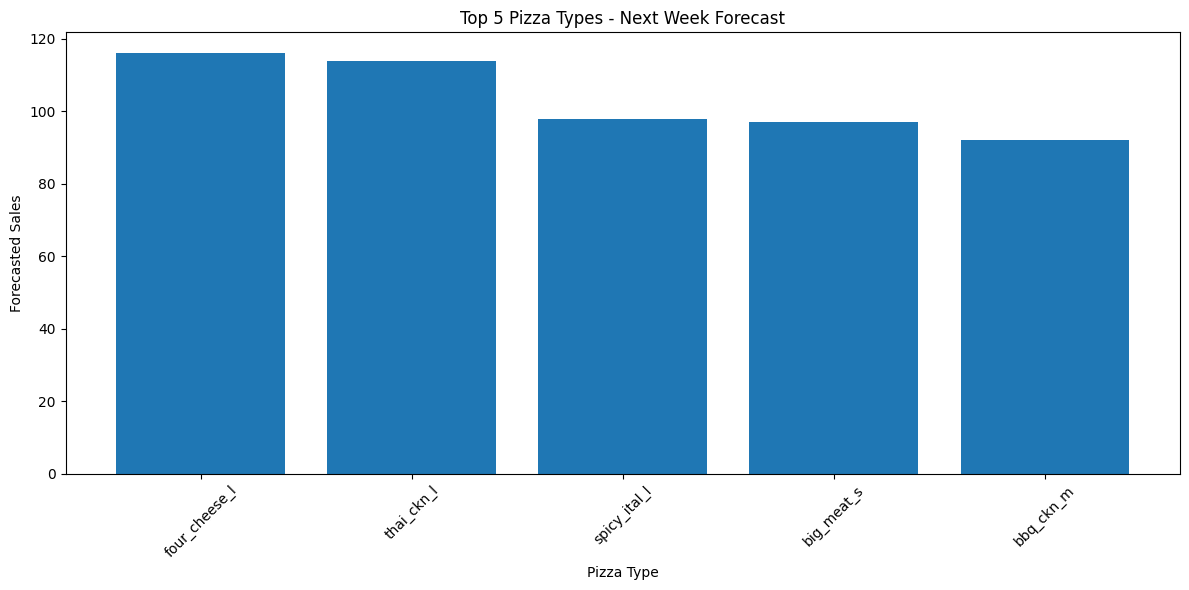

In [98]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

def prepare_weekly_sales_by_pizza(df):
    # Convert order date to datetime if not already
    df['order_date'] = pd.to_datetime(df['order_date'])

    # Group by week and pizza type, summing the quantities
    weekly_sales = df.groupby([
        df['order_date'].dt.to_period('W').apply(lambda r: r.start_time),
        'pizza_name_id'
    ])['quantity'].sum().reset_index()

    return weekly_sales

def forecast_pizza_type_sales(pizza_type_data, best_params):
    """
    Forecast sales for a specific pizza type using the best SARIMA parameters
    we found earlier: (1, 0, 1)x(2, 0, 0, 7)
    """
    try:
        model = SARIMAX(
            pizza_type_data,
            order=(best_params[0], best_params[1], best_params[2]),
            seasonal_order=(best_params[3], best_params[4], best_params[5], best_params[6]),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        # Forecast one week ahead
        forecast = model.forecast(steps=1)
        return max(0, forecast[0])  # Ensure we don't get negative predictions
    except:
        # If model fails, return the mean of the last 4 weeks as a fallback
        return max(0, pizza_type_data.tail(4).mean())

# Prepare the data by pizza type
pizza_sales_weekly_by_pizza = prepare_weekly_sales_by_pizza(merged_data)

# Best parameters from our earlier analysis
best_params = (1, 0, 1, 2, 0, 0, 7)

# Dictionary to store forecasts for each pizza type
pizza_forecasts = {}

# Get the last date in our dataset
last_date = pizza_sales_weekly_by_pizza['order_date'].max()
forecast_date = last_date + pd.Timedelta(weeks=1)

# Calculate forecasts for each pizza type
for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
    # Get historical data for this pizza type
    pizza_type_data = pizza_sales_weekly_by_pizza[
        pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type
    ].set_index('order_date')['quantity']

    # Generate forecast
    forecast = forecast_pizza_type_sales(pizza_type_data, best_params)

    # Store rounded forecast
    pizza_forecasts[pizza_type] = int(round(forecast))

# Print results
print(f"\nForecasted sales for the week {forecast_date.date()} to {(forecast_date + pd.Timedelta(days=6)).date()}:")
total_forecast = 0

# Sort pizza types for better readability
for pizza_type in sorted(pizza_forecasts.keys()):
    forecast = pizza_forecasts[pizza_type]
    print(f"{pizza_type}: {forecast} pizzas")
    total_forecast += forecast

print(f"\nTotal forecasted pizzas: {total_forecast}")

# Optional: Create visualization for top 5 pizza types by forecast volume
plt.figure(figsize=(12, 6))
top_5_pizzas = dict(sorted(pizza_forecasts.items(), key=lambda x: x[1], reverse=True)[:5])
plt.bar(top_5_pizzas.keys(), top_5_pizzas.values())
plt.title('Top 5 Pizza Types - Next Week Forecast')
plt.xlabel('Pizza Type')
plt.ylabel('Forecasted Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

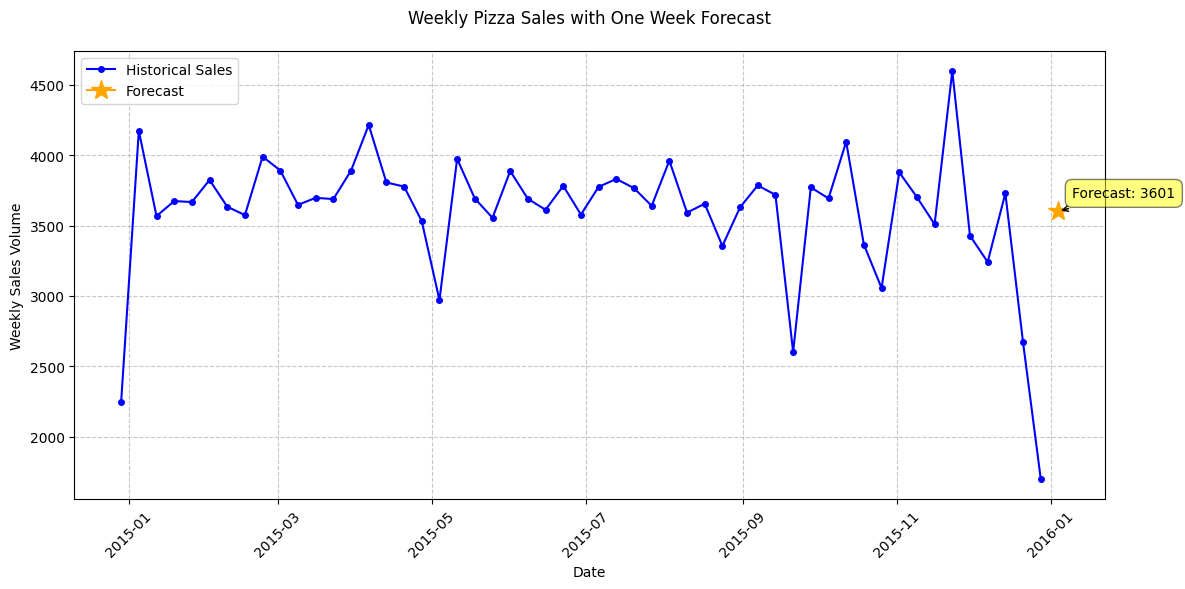


Forecast for week starting 2016-01-04:
Predicted sales: 3601 units


In [99]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# First, let's prepare our weekly sales data
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

# Prepare the data using all available observations
pizza_sales_weekly = prepare_weekly_sales(merged_data)

# Use our previously identified best parameters
# SARIMA(1, 0, 1)x(2, 0, 0, 7) was our best model
best_params = (1, 0, 1, 2, 0, 0, 7)

# Fit the SARIMAX model using the entire dataset
model = SARIMAX(
    pizza_sales_weekly,
    order=(best_params[0], best_params[1], best_params[2]),
    seasonal_order=(best_params[3], best_params[4], best_params[5], best_params[6]),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Generate forecast for the next week
# The start date will be the day after our last observation
forecast_start = pizza_sales_weekly.index[-1] + pd.Timedelta(days=1)
forecast = model.forecast(steps=1)  # We're forecasting one week ahead

# Create the visualization
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(pizza_sales_weekly.index, pizza_sales_weekly.values,
         label='Historical Sales', color='blue', marker='o', markersize=4)

# Plot the forecast
# We'll create a date range for our forecast point
forecast_dates = pd.date_range(start=forecast_start, periods=1, freq='W-MON')
plt.plot(forecast_dates, forecast.values,
         label='Forecast', color='orange', marker='*', markersize=15)

# Customize the plot
plt.title('Weekly Pizza Sales with One Week Forecast', fontsize=12, pad=20)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Weekly Sales Volume', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.legend()

# Add forecast value annotation
plt.annotate(f'Forecast: {int(forecast.values[0])}',
            xy=(forecast_dates[0], forecast.values[0]),
            xytext=(10, 10), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle='->'))

# Ensure layout looks good
plt.tight_layout()

# Display the plot
plt.show()

# Print the numerical forecast
print(f"\nForecast for week starting {forecast_dates[0].date()}:")
print(f"Predicted sales: {int(forecast.values[0])} units")


Predicted ingredient requirements for week starting 2016-01-04:
?duja Salami: 3820.00 grams
Alfredo Sauce: 1205.00 grams
Anchovies: 2450.00 grams
Artichokes: 10040.00 grams
Arugula: 830.00 grams
Asiago Cheese: 5910.00 grams
Bacon: 27510.00 grams
Barbecue Sauce: 2195.00 grams
Barbecued Chicken: 6280.00 grams
Beef Chuck Roast: 12850.00 grams
Blue Cheese: 1380.00 grams
Brie Carre Cheese: 1680.00 grams
Calabrese Salami: 11850.00 grams
Capocollo: 59250.00 grams
Caramelized Onions: 896.00 grams
Chicken: 80950.00 grams
Chipotle Sauce: 6860.00 grams
Chorizo Sausage: 4850.00 grams
Cilantro: 3430.00 grams
Coarse Sicilian Salami: 12560.00 grams
Corn: 23000.00 grams
Eggplant: 2520.00 grams
Feta Cheese: 10620.00 grams
Fontina Cheese: 5470.00 grams
Friggitello Peppers: 955.00 grams
Garlic: 23650.00 grams
Genoa Salami: 8910.00 grams
Goat Cheese: 13020.00 grams
Gorgonzola Piccante Cheese: 5580.00 grams
Gouda Cheese: 4280.00 grams
Green Olives: 4190.00 grams
Green Peppers: 6320.00 grams
Italian Sausag

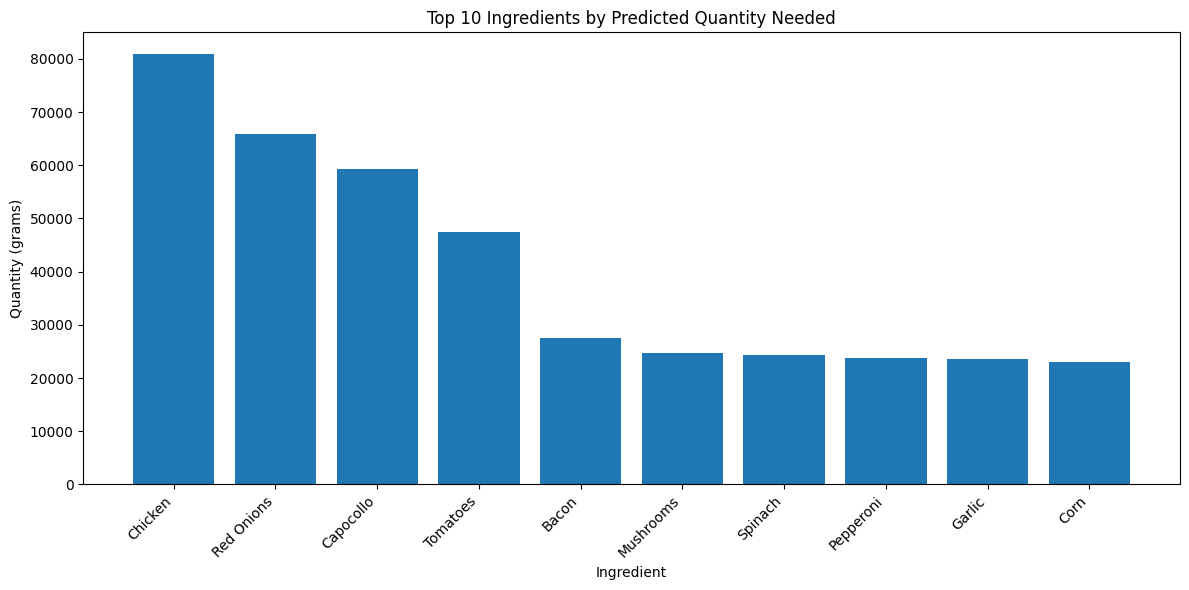


Detailed ingredients prediction dataframe:
  pizza_name_id                  pizza_name  pizza_ingredients  \
0     bbq_ckn_l  The Barbecue Chicken Pizza  Barbecued Chicken   
1     bbq_ckn_l  The Barbecue Chicken Pizza        Red Peppers   
2     bbq_ckn_l  The Barbecue Chicken Pizza      Green Peppers   
3     bbq_ckn_l  The Barbecue Chicken Pizza           Tomatoes   
4     bbq_ckn_l  The Barbecue Chicken Pizza         Red Onions   

   Items_Qty_In_Grams  predicted_quantity  total_ingredient_qty  
0                40.0                  79                3160.0  
1                15.0                  79                1185.0  
2                20.0                  79                1580.0  
3                30.0                  79                2370.0  
4                60.0                  79                4740.0  


In [100]:
# First, let's make sure our forecast results are in a usable format
def prepare_ingredient_forecasts(pizza_sales_weekly_by_pizza, best_params):
    """
    Generate forecasts for each pizza type and prepare them for ingredient calculation
    """
    pizza_forecasts = {}

    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        # Get historical data for this pizza type
        pizza_type_data = pizza_sales_weekly_by_pizza[
            pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type
        ].set_index('order_date')['quantity']

        # Fit SARIMA model and generate forecast
        try:
            model = SARIMAX(
                pizza_type_data,
                order=(best_params[0], best_params[1], best_params[2]),
                seasonal_order=(best_params[3], best_params[4], best_params[5], best_params[6]),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)

            forecast = model.forecast(steps=1)
            pizza_forecasts[pizza_type] = int(round(max(0, forecast[0])))
        except:
            # Fallback to mean of last 4 weeks if model fails
            pizza_forecasts[pizza_type] = int(round(pizza_type_data.tail(4).mean()))

    return pizza_forecasts

# Generate our pizza forecasts
pizza_forecasts = prepare_ingredient_forecasts(pizza_sales_weekly_by_pizza, best_params)

# Now let's calculate ingredient requirements based on these forecasts
def calculate_ingredient_requirements(Ingredients_dataset, pizza_forecasts):
    """
    Calculate the required quantities of ingredients based on pizza sales forecasts
    """
    # Create a copy of the ingredients dataset to avoid modifying the original
    ingredients_predicted = Ingredients_dataset.copy()

    # Map the predicted sales quantities to each pizza type
    ingredients_predicted['predicted_quantity'] = ingredients_predicted['pizza_name_id'].map(pizza_forecasts)

    # Calculate total ingredient quantities needed
    ingredients_predicted['total_ingredient_qty'] = (
        ingredients_predicted['Items_Qty_In_Grams'] *
        ingredients_predicted['predicted_quantity']
    )

    # Group by ingredient and sum up total quantities needed
    ingredient_totals = ingredients_predicted.groupby('pizza_ingredients')['total_ingredient_qty'].sum()

    return ingredients_predicted, ingredient_totals

# Calculate ingredient requirements
ingredients_predicted, ingredient_totals = calculate_ingredient_requirements(
    Ingredients_dataset, pizza_forecasts
)

# Display the results
print(f"\nPredicted ingredient requirements for week starting {forecast_dates[0].date()}:")
for ingredient, quantity in ingredient_totals.items():
    print(f"{ingredient}: {quantity:.2f} grams")

# Create a visualization of top ingredients by quantity
plt.figure(figsize=(12, 6))
top_10_ingredients = ingredient_totals.nlargest(10)
plt.bar(top_10_ingredients.index, top_10_ingredients.values)
plt.title('Top 10 Ingredients by Predicted Quantity Needed')
plt.xlabel('Ingredient')
plt.ylabel('Quantity (grams)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Return the detailed ingredients DataFrame for further analysis
print("\nDetailed ingredients prediction dataframe:")
print(ingredients_predicted.head())

In [101]:
# Saveing the ingredient totals to a DataFrame
ingredient_totals_df = pd.DataFrame(ingredient_totals.items(), columns=['Ingredient', 'Total Quantity (grams)'])
ingredient_totals_df.to_csv('predicted_ingredient_totals1.csv', index=False)
print("Predicted ingredient totals saved to 'predicted_ingredient_totals1.csv'")

Predicted ingredient totals saved to 'predicted_ingredient_totals.csv'


In [102]:
print(ingredients_predicted)

    pizza_name_id                         pizza_name  pizza_ingredients  \
0       bbq_ckn_l         The Barbecue Chicken Pizza  Barbecued Chicken   
1       bbq_ckn_l         The Barbecue Chicken Pizza        Red Peppers   
2       bbq_ckn_l         The Barbecue Chicken Pizza      Green Peppers   
3       bbq_ckn_l         The Barbecue Chicken Pizza           Tomatoes   
4       bbq_ckn_l         The Barbecue Chicken Pizza         Red Onions   
..            ...                                ...                ...   
513  veggie_veg_s  The Vegetables + Vegetables Pizza      Green Peppers   
514  veggie_veg_s  The Vegetables + Vegetables Pizza         Red Onions   
515  veggie_veg_s  The Vegetables + Vegetables Pizza           Zucchini   
516  veggie_veg_s  The Vegetables + Vegetables Pizza            Spinach   
517  veggie_veg_s  The Vegetables + Vegetables Pizza             Garlic   

     Items_Qty_In_Grams  predicted_quantity  total_ingredient_qty  
0                  40.0        